## Project Description & Problem Setting

### Sentinel‑2 Multiclass Land‑Cover & Cloud Classification

**Problem Setting**  
This project addresses **satellite image classification in Sentinel-2 imagery** as a **supervised multiclass classification task** using both pixel-based and patch-based approaches. Data Source: [CODE-DE Data Explorer (Sentinel-2)](https://explore.code-de.org/search?searchForm=H4sIAAAAAAAAE61SwW4aMRD9lzl7ow0RrdY3BFRCCpDC9pKqh2E9wEhee2XPUqFo%252F70y0AKRUpGmki9%252B82bevGe%252FQBO8aSuZYU2gXWutuoSmKNW23DcEGhoMwmhBAe6QLa7YsuxBA9c1GUYhUMA1bijsU0sE%252Ff2Hgsr61gz9jsLv%252BbJvaL4eoSQKRHKR3eZ4VWBQaIFuQ6BfIAoGSRXQ0Mt7%252FSwvsvy%252BzHN9OHd5nj%252BDAnLmNelz2XvQ%252FUL3i7uiKJ6hU1ChoPWbliYGNFTeUGbSyjXHyN7FJLgcz8rJbPyY3R%252FkyVIlZECv0UZSsPah%252FsJkzYHcWJSELCkw2okhJ7zm5DP5boKvKCZrj7Qj%252BwdM0R4TTYBwTZYdxVNavqGAwt6hnXpzIvmwYhlxoCpVjlggi8I7mqfarK1X53wbbzFwPIwZbtE5sqfp8SfK9nLR1NB16uy7d%252B1bQvt%252B29cO31z0Svfhw3mzixLampwstz6cPvQHHuI9mV9Z6T%252Fd4uWmpc6sV5%252FhTfFPN2j%252F56T%252Bmko5XiwGg6%252FfBrdlcqmU2ofzp2w0nv5Lc9f9Am8nUObdBAAA).

Each pixel is represented by a 10-dimensional spectral vector (corresponding to 10 Sentinel-2 bands at 20m resolution), and labeled based on the Scene Classification Layer (SCL), which has been remapped into four meaningful land surface classes:
- `0`: Vegetation  
- `1`: Bare Soil  
- `2`: Water  
- `3`: Cloud  
- `-1`: Ignored (not used in training)

**Dataset**  
The dataset consists of 8 Sentinel-2 Level-2A scenes in `.SAFE` format. From each scene, we extract:
- 10 spectral bands at 20m resolution (`B01`, `B02`, `B03`, `B04`, `B05`, `B06`, `B07`, `B8A`, `B11`, `B12`)
- SCL masks at 20m resolution for ground truth labels

Each scene covers approximately **110km × 110km** (5490×5490 pixels at 20m resolution). After removing ignored pixels, the dataset contains **213 million labeled pixels** with the following distribution:
- Vegetation: 56.2% (119.8M pixels)
- Bare Soil: 18.2% (38.8M pixels)  
- Water: 8.9% (19.0M pixels)
- Cloud: 16.7% (35.4M pixels)

**Learning Task**  
- **Type**: Supervised multiclass classification  
- **Input**: Single pixel → 10-band spectral vector  
- **Output**: One of four land cover or cloud class labels  
- **Evaluation Metrics**: Overall accuracy, per-class precision/recall/F1, macro-averaged F1 score, confusion matrix

**Experimental Setup**  
Due to computational constraints, we work with a **stratified sample of 1 million pixels** (0.47% of total data) for model development and comparison. All models are trained on identical data splits (60% train, 20% validation, 20% test) with standardized features to ensure fair comparison.

**Project Goals**  
1. **Establish baseline performance** using pixel-based MLP to understand spectral-only classification
2. **Identify and address class imbalance** issues that affect minority classes (water and cloud)
3. **Compare pixel vs. patch approaches** to quantify the value of spatial context:
   - Pixel-based: MLP variants (baseline, regularized, weighted)
   - Patch-based: CNN (Baseline and Advanced)
     
4. **Analyze trade-offs** between model complexity, performance, and computational efficiency
**Key Challenges**
- **Class imbalance**: Vegetation dominates the dataset (3.3× more samples than cloud)
- **Spectral similarity**: Different land covers may have overlapping spectral signatures
- **Lack of spatial context**: Pixel-based methods ignore neighboring information
- **Scale**: Balancing computational efficiency with model performance on large-scale data

**Expected Contributions**
This project provides:
1. A systematic comparison of deep learning approaches for Sentinel-2 satellite image classification
2. Analysis of how architectural choices impact performance on imbalanced satellite data
3. Practical insights for deploying ML models on large-scale Earth observation data
4. Reproducible pipeline for multi-class classification of Sentinel-2 imagery

## Section 1: Library Import & Data Loading

### 1.1 Import Libraries and System Configuration 

In [1]:
# General
import os, json, time, random
import glob
import gc
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import from_origin
from rasterio.crs import CRS
import rioxarray

# ML/DL
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Progress bar
from tqdm import tqdm


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Reproducibility & Device
TEST_SIZE = 0.2
VAL_SIZE = 0.25  # 25% of remaining 80% = 20% of total
BATCH_SIZE = 1024
SEED = 42
SAMPLE_SIZE = 1_000_000 
np.random.seed(SEED)
torch.manual_seed(SEED)

device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print(f" Device: {device}")

 Device: mps


### 1.2 Dataset
Discovers all Sentinel-2 .SAFE scenes for further processing.

In [3]:
# Paths & Constants
SAFE_BASE_DIR = "data"
BANDS = ["B01","B02","B03","B04","B05","B06","B07","B8A","B11","B12"]
LABEL_NAME = "SCL"
BAND_SUFFIX = "_20m.jp2"
CLASS_NAMES = ["Vegetation","Bare Soil","Water","Cloud"]
NUM_CLASSES = 4

# Find all .SAFE folders inside 'data/'
safe_folders = sorted(glob.glob(os.path.join(SAFE_BASE_DIR, "*.SAFE")))

print(f"Found {len(safe_folders)} scenes:")
for folder in safe_folders:
    print("–", os.path.basename(folder))

Found 8 scenes:
– S2A_MSIL2A_20150704T101006_N0500_R022_T32UPU_20231012T100650.SAFE
– S2A_MSIL2A_20150704T101006_N0500_R022_T32UQC_20231012T100650.SAFE
– S2A_MSIL2A_20150704T101006_N0500_R022_T32UQD_20231012T100650.SAFE
– S2A_MSIL2A_20150802T104026_N0500_R008_T32ULA_20231010T074654.SAFE
– S2A_MSIL2A_20150802T104026_N0500_R008_T32ULB_20231010T074654.SAFE
– S2A_MSIL2A_20150802T104026_N0500_R008_T32ULV_20231010T074654.SAFE
– S2A_MSIL2A_20150806T102016_N0500_R065_T33UUA_20231010T130138.SAFE
– S2A_MSIL2A_20150806T102016_N0500_R065_T33UUV_20231010T130138.SAFE


### 1.3 Load Scenes
Loads all 10 spectral bands and the SCL label for one scene.

In [5]:
def load_scene(scene_path):
    granule_path = glob.glob(os.path.join(scene_path, "GRANULE", "*"))[0]
    r20m_path = os.path.join(granule_path, "IMG_DATA", "R20m")
    # read bands
    bands = []
    for b in BANDS:
        band_file = glob.glob(os.path.join(r20m_path, f"*_{b}{BAND_SUFFIX}"))[0]
        with rasterio.open(band_file) as src:
            bands.append(src.read(1).astype(np.float32))
    cube = np.stack(bands)  # (10,H,W)

    # read SCL
    scl_file = glob.glob(os.path.join(r20m_path, f"*_{LABEL_NAME}{BAND_SUFFIX}"))[0]
    with rasterio.open(scl_file) as src:
        scl = src.read(1).astype(np.uint8)
    return cube, scl

if os.path.exists("all_cubes.npy") and os.path.exists("all_labels.npy"):
    print(" Loading all_cubes / all_labels from cache...")
    all_cubes  = np.load("all_cubes.npy",  mmap_mode='r')  # (N,10,H,W)
    all_labels = np.load("all_labels.npy", mmap_mode='r')  # (N,H,W)
else:
    print(" Reading .SAFE scenes...")
    cubes, labels, Hs, Ws = [], [], [], []
    for folder in safe_folders:
        cube, scl = load_scene(folder)
        cubes.append(cube); labels.append(scl)
        Hs.append(cube.shape[1]); Ws.append(cube.shape[2])
    H, W = min(Hs), min(Ws)  # crop to smallest common size
    for i in range(len(cubes)):
        cubes[i]  = cubes[i][:, :H, :W]
        labels[i] = labels[i][:H, :W]
    all_cubes  = np.array(cubes,  dtype=np.float32)
    all_labels = np.array(labels, dtype=np.uint8)
    np.save("all_cubes.npy",  all_cubes)
    np.save("all_labels.npy", all_labels)
    print(" Saved all_cubes.npy / all_labels.npy")
print(" cubes:", all_cubes.shape, "labels:", all_labels.shape)


 Loading all_cubes / all_labels from cache...
 cubes: (8, 10, 5490, 5490) labels: (8, 5490, 5490)


## Section 2: Exploratory Data Analysis

In [6]:
# Scene overview (counts, shapes, coverage)

num_scenes, num_bands, H, W = all_cubes.shape
pixel_size_m = 20  # Sentinel-2 at 20 m
coverage_km = (H * pixel_size_m) / 1000

print(f"Scenes: {num_scenes}  |  Bands per scene: {num_bands}")
print(f"Per-scene raster size: {H} × {W} px  (~{coverage_km:.1f} × {coverage_km:.1f} km)")
print("Bands:", ", ".join(BANDS))


Scenes: 8  |  Bands per scene: 10
Per-scene raster size: 5490 × 5490 px  (~109.8 × 109.8 km)
Bands: B01, B02, B03, B04, B05, B06, B07, B8A, B11, B12


In [5]:
print("Dataset Overview")
print("="*40)
print(f"Number of scenes: {len(all_cubes)}")
print(f"Data shape: {all_cubes.shape} (scenes, bands, height, width)")
print(f"Label shape: {all_labels.shape}")
print(f"Band names: {BANDS}")


Dataset Overview
Number of scenes: 8
Data shape: (8, 10, 5490, 5490) (scenes, bands, height, width)
Label shape: (8, 5490, 5490)
Band names: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12']


In [8]:
# SCL distribution
import collections
# Sentinel‑2 SCL legend (original codes)
SCL_NAMES = {
    0: "No Data", 1: "Saturated/Defective", 2: "Dark Area", 3: "Cloud Shadows",
    4: "Vegetation", 5: "Bare Soils", 6: "Water", 7: "Unclassified",
    8: "Cloud (Med Prob)", 9: "Cloud (High Prob)", 10: "Thin Cirrus", 11: "Snow/Ice"
}

overall = collections.Counter()
per_scene = []

for i in range(num_scenes):
    u, c = np.unique(all_labels[i], return_counts=True)
    d = dict(zip(u, c))
    per_scene.append(d)
    overall.update(d)

# Print compact table: overall counts for codes present
total_px = sum(overall.values())
print("Overall SCL distribution:")
print(f"{'Code':>4}  {'Name':<20}  {'Pixels':>12}  {'%':>6}")
print("-"*48)
for k in sorted(overall.keys()):
    name = SCL_NAMES.get(k, f"Code {k}")
    cnt = overall[k]
    pct = 100 * cnt / total_px
    print(f"{k:>4}  {name:<20}  {cnt:>12,}  {pct:>6.2f}")


Overall SCL distribution:
Code  Name                        Pixels       %
------------------------------------------------
   0  No Data                 26,686,130   11.07
   2  Dark Area                  155,223    0.06
   3  Cloud Shadows              889,020    0.37
   4  Vegetation             119,762,936   49.67
   5  Bare Soils              38,823,931   16.10
   6  Water                   19,029,195    7.89
   7  Unclassified               339,777    0.14
   8  Cloud (Med Prob)         2,404,463    1.00
   9  Cloud (High Prob)          717,438    0.30
  10  Thin Cirrus             32,312,680   13.40
  11  Snow/Ice                         7    0.00


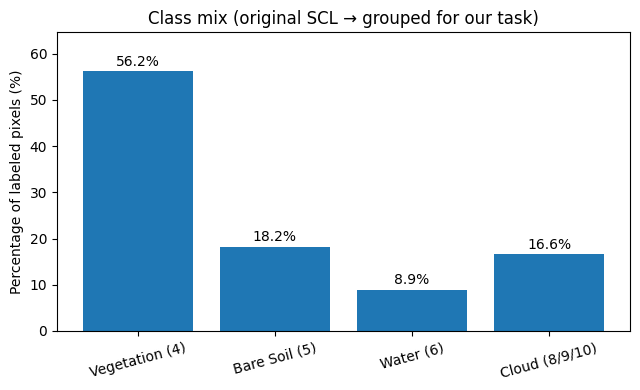

In [9]:
# Class Distribution
veg = overall.get(4, 0)
soil = overall.get(5, 0)
water = overall.get(6, 0)
cloud = overall.get(8, 0) + overall.get(9, 0) + overall.get(10, 0)

labels = ["Vegetation (4)", "Bare Soil (5)", "Water (6)", "Cloud (8/9/10)"]
vals = np.array([veg, soil, water, cloud], dtype=np.int64)
pct = 100 * vals / vals.sum()

plt.figure(figsize=(6.5,4))
bars = plt.bar(labels, pct)
plt.ylabel("Percentage of labeled pixels (%)")
plt.title("Class mix (original SCL → grouped for our task)")
for b, p in zip(bars, pct):
    plt.text(b.get_x() + b.get_width()/2, b.get_height() + 0.5, f"{p:.1f}%", ha="center", va="bottom")
plt.xticks(rotation=15)
plt.ylim(0, max(pct)*1.15)
plt.tight_layout()
plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


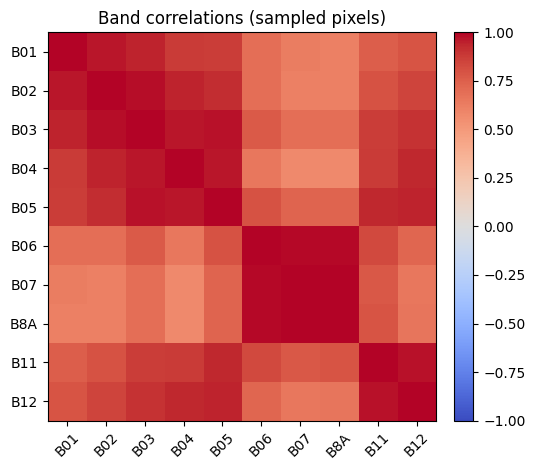

In [17]:
# Band correlation (sampled)

# Pearson correlation on the same sample
corr = np.corrcoef(X_sample.T)  # (C, C)

plt.figure(figsize=(5.5,4.8))
im = plt.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
plt.xticks(range(num_bands), BANDS, rotation=45)
plt.yticks(range(num_bands), BANDS)
plt.title("Band correlations (sampled pixels)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


In [37]:
# Sample Scene Visualization

import numpy as np

def stretch_img(arr, lo=2, hi=98):
    """
    Percentile stretch to [0,1] for display.
    Works on 2D arrays (H,W) or 3‑channel (H,W,3) arrays.
    """
    arr = arr.astype(np.float32)
    p_low  = np.percentile(arr, lo, axis=None, keepdims=True)
    p_high = np.percentile(arr, hi, axis=None, keepdims=True)
    out = (arr - p_low) / (p_high - p_low + 1e-6)
    return np.clip(out, 0, 1)

def make_rgb(cube, bands, r="B04", g="B03", b="B02", lo=2, hi=98):
    """Create a stretched RGB from a cube (C,H,W) and band list."""
    ir, ig, ib = bands.index(r), bands.index(g), bands.index(b)
    rgb = np.stack([cube[ir], cube[ig], cube[ib]], axis=-1)
    return stretch_img(rgb, lo=lo, hi=hi)



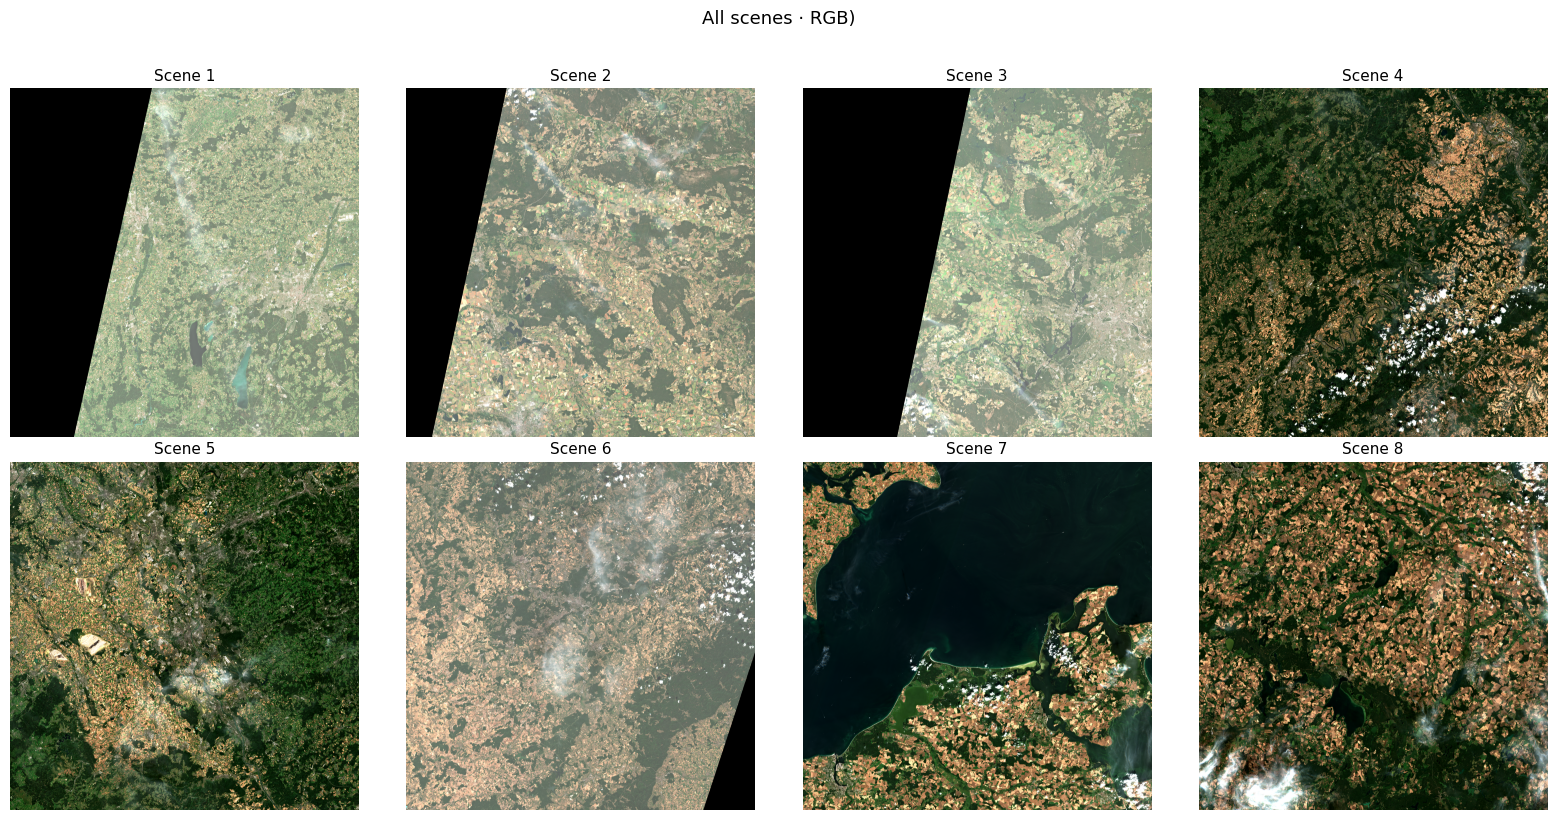

In [38]:
# show every scene in a grid using B04/B03/B02
n = len(all_cubes)
n_cols = 4
n_rows = int(np.ceil(n / n_cols))

plt.figure(figsize=(4.0*n_cols, 4.0*n_rows))
for s in range(n):
    ax = plt.subplot(n_rows, n_cols, s+1)
    rgb = make_rgb(all_cubes[s], BANDS, r="B04", g="B03", b="B02", lo=2, hi=98)
    ax.imshow(rgb)
    ax.set_title(f"Scene {s+1}", fontsize=11)
    ax.axis("off")
plt.suptitle("All scenes · RGB)", y=1.02, fontsize=13)
plt.tight_layout()
plt.show()


## Section 3: Data Preprocessing

In [10]:
# 3.1 — Remapping SCL → {0:veg,1:soil,2:water,3:cloud,-1:ignored}

def remap_scl_labels(scl: np.ndarray) -> np.ndarray:
    
    out = np.full(scl.shape, -1, dtype=np.int8)
    out[scl == 4] = 0
    out[scl == 5] = 1
    out[scl == 6] = 2
    out[np.isin(scl, [8, 9, 10])] = 3
    return out
print(" remap_scl_labels() ready")


 remap_scl_labels() ready


In [5]:
# 3.2 — Apply remap to each scene label map (H×W) and cache

if os.path.exists("remapped_labels.npy"):
    print(" Loading remapped_labels.npy ...")
    remapped_labels = np.load("remapped_labels.npy", mmap_mode="r") 
else:
    print(" Remapping SCL labels for all scenes...")
    remapped_labels = np.stack([remap_scl_labels(lbl) for lbl in all_labels]).astype(np.int8)
    np.save("remapped_labels.npy", remapped_labels)
    print(" Saved remapped_labels.npy")

print("shape:", remapped_labels.shape)


 Loading remapped_labels.npy ...
shape: (8, 5490, 5490)


In [12]:
# 3.3 — Distribution check

from collections import Counter

total = Counter()
for i, r in enumerate(remapped_labels):
    u, c = np.unique(r, return_counts=True)
    d = dict(zip(u, c))
    total.update(d)
    nice = { {-1:"Ignored",0:"Vegetation",1:"Bare Soil",2:"Water",3:"Cloud"}.get(k, k): v for k, v in d.items() }
    print(f"Scene {i+1}: {nice}")

valid_total = sum(v for k, v in total.items() if k != -1)
print("\nTotals (all scenes)")
for k in [-1,0,1,2,3]:
    if k in total:
        name = "Ignored" if k == -1 else ["Vegetation","Bare Soil","Water","Cloud"][k]
        print(f"{name:>10}: {total[k]:,}")
print(f"\nValid pixels (exclude -1): {valid_total:,}")


Scene 1: {'Ignored': 8933479, 'Vegetation': 16105448, 'Bare Soil': 1577257, 'Water': 217996, 'Cloud': 3305920}
Scene 2: {'Ignored': 5573250, 'Vegetation': 15244241, 'Bare Soil': 5046839, 'Water': 201652, 'Cloud': 4074118}
Scene 3: {'Ignored': 11389626, 'Vegetation': 13822738, 'Bare Soil': 2533222, 'Water': 394344, 'Cloud': 2000170}
Scene 4: {'Ignored': 373017, 'Vegetation': 20354544, 'Bare Soil': 4792180, 'Water': 131094, 'Cloud': 4489265}
Scene 5: {'Ignored': 114228, 'Vegetation': 20031316, 'Bare Soil': 5576338, 'Water': 235465, 'Cloud': 4182753}
Scene 6: {'Ignored': 1365131, 'Vegetation': 15323161, 'Bare Soil': 6946950, 'Water': 82885, 'Cloud': 6421973}
Scene 7: {'Ignored': 160525, 'Vegetation': 5344333, 'Bare Soil': 4356461, 'Water': 16699678, 'Cloud': 3579103}
Scene 8: {'Ignored': 160901, 'Vegetation': 13537155, 'Bare Soil': 7994684, 'Water': 1066081, 'Cloud': 7381279}

Totals (all scenes)
   Ignored: 28,070,157
Vegetation: 119,762,936
 Bare Soil: 38,823,931
     Water: 19,029,195


In [6]:
# 3.4 — Flatten to pixel table X_clean (M×10), y_clean (M,), and record origins (M×3)
#       origins[row] = (scene_id, row, col) so we can extract patches later.

if all(os.path.exists(f) for f in ["X_clean.npy","y_clean.npy","origins.npy"]):
    print(" Loading X_clean / y_clean / origins from cache...")
    X_clean = np.load("X_clean.npy", mmap_mode="r")   # (M, 10) float32
    y_clean = np.load("y_clean.npy", mmap_mode="r")   # (M,)    int8
    origins = np.load("origins.npy", mmap_mode="r")   # (M,3)   int32 (scene,row,col)
else:
    print(" Building X_clean / y_clean / origins from cubes + remapped labels...")
    N, C, H, W = all_cubes.shape
    feats_list, labels_list, origins_list = [], [], []

    for s in range(N):
        lbl = remapped_labels[s]          # (H, W), int8
        mask = (lbl != -1)                # valid pixels
        if not mask.any():
            continue

        # features (H, W, 10)
        feats = all_cubes[s].transpose(1, 2, 0)  # (H, W, C)
        feats_list.append(feats[mask].astype(np.float32))  # (K, C)
        labels_list.append(lbl[mask].astype(np.int8))      # (K,)

        rs, cs = np.where(mask)
        ss = np.full(rs.shape, s, dtype=np.int32)
        origins_list.append(np.stack([ss, rs.astype(np.int32), cs.astype(np.int32)], axis=1))  # (K,3)

    X_clean = np.concatenate(feats_list, axis=0)
    y_clean = np.concatenate(labels_list, axis=0)
    origins = np.concatenate(origins_list, axis=0)

    np.save("X_clean.npy", X_clean)
    np.save("y_clean.npy", y_clean)
    np.save("origins.npy", origins)
    print(" Saved X_clean.npy / y_clean.npy / origins.npy")

print(" Clean pixels:", X_clean.shape, "| labels:", y_clean.shape, "| origins:", origins.shape)


 Loading X_clean / y_clean / origins from cache...
 Clean pixels: (213050643, 10) | labels: (213050643,) | origins: (213050643, 3)


Class distribution (post‑remap & excluding ignored):
  Vegetation: 119,762,936  (56.2%)
   Bare Soil: 38,823,931  (18.2%)
       Water: 19,029,195  (8.9%)
       Cloud: 35,434,581  (16.6%)


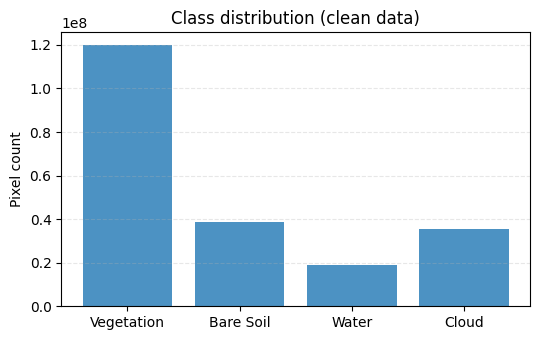

In [14]:
# Class distribution (bar + counts)

CLASS_NAMES = ["Vegetation", "Bare Soil", "Water", "Cloud"]

unique, counts = np.unique(y_clean, return_counts=True)
counts_dict = {CLASS_NAMES[u]: c for u, c in zip(unique, counts)}

# Print nice summary
total = counts.sum()
print("Class distribution (post‑remap & excluding ignored):")
for name in CLASS_NAMES:
    c = counts_dict.get(name, 0)
    print(f"  {name:>10}: {c:,}  ({100*c/total:.1f}%)")

# Bar plot
plt.figure(figsize=(5.5, 3.5))
plt.bar([CLASS_NAMES[u] for u in unique], counts, alpha=0.8)
plt.ylabel("Pixel count")
plt.title("Class distribution (clean data)")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


## Section 4: Split, Normalization, and Data Loader

Train/Validation/Test Split (Stratified, 60/20/20)

We split first so we can fit the scaler only on the training set (avoids data leakage), then apply it to val/test.

In [8]:
print(f"\n Sampling Strategy: {SAMPLE_SIZE:,} pixels")
print(f"   Original dataset: {len(X_clean):,} pixels")
print(f"   Sample ratio: {SAMPLE_SIZE/len(X_clean)*100:.2f}%")
print(f"   Memory requirement: ~{SAMPLE_SIZE * 10 * 4 / 1e9:.2f} GB")


 Sampling Strategy: 1,000,000 pixels
   Original dataset: 213,050,643 pixels
   Sample ratio: 0.47%
   Memory requirement: ~0.04 GB


In [18]:
# Now extract the actual samples (this loads into memory)
print(" Extracting sampled data...")
X_sample = X_clean[sample_indices]  # This creates a copy in memory
y_sample = y_clean[sample_indices]
origins_sample = origins[sample_indices]

 Extracting sampled data...


In [101]:
# Sampling (only runs if no cached splits exist)

if not all(os.path.exists(f) for f in [
    "X_train_raw.npy","X_val_raw.npy","X_test_raw.npy",
    "y_train.npy","y_val.npy","y_test.npy",
    "origins_train.npy","origins_val.npy","origins_test.npy"
]):
    print(" No cached splits found → performing sampling + split...")
    
    # Stratified sampling
    sample_indices = train_test_split(
        np.arange(len(X_clean)),
        train_size=SAMPLE_SIZE,
        stratify=y_clean,
        random_state=SEED
    )[0]
    X_sample = X_clean[sample_indices]
    y_sample = y_clean[sample_indices]
    origins_sample = origins[sample_indices]

    # Then do your train/val/test split here...
    # and save them as before.
else:
    print(" Cached splits found → skipping sampling.")


 Cached splits found → skipping sampling.


In [102]:

# Stratified Sampling + Train/Val/Test Splits (cached)

SPLIT_FILES = [
    "X_train_raw.npy","X_val_raw.npy","X_test_raw.npy",
    "y_train.npy","y_val.npy","y_test.npy",
    "origins_train.npy","origins_val.npy","origins_test.npy"
]

if all(os.path.exists(p) for p in SPLIT_FILES):
    print(" Loading cached splits…")
    X_train = np.load("X_train_raw.npy");  y_train = np.load("y_train.npy");  origins_train = np.load("origins_train.npy")
    X_val   = np.load("X_val_raw.npy");    y_val   = np.load("y_val.npy");    origins_val   = np.load("origins_val.npy")
    X_test  = np.load("X_test_raw.npy");   y_test  = np.load("y_test.npy");   origins_test  = np.load("origins_test.npy")
else:
    print(" Creating stratified sample & 60/20/20 splits…")
    # 1) stratified pre-sample on indices (keeps original class ratios)
    M = len(y_clean)
    if SAMPLE_SIZE > M: SAMPLE_SIZE = M
    sss = StratifiedShuffleSplit(n_splits=1, train_size=SAMPLE_SIZE, random_state=SEED)
    sample_idx, _ = next(sss.split(np.zeros(M), y_clean))

    # 2) materialize the sample once
    X_sample       = X_clean[sample_idx]
    y_sample       = y_clean[sample_idx]
    origins_sample = origins[sample_idx]

    # 3) split sample into test and train+val
    X_temp, X_test, y_temp, y_test, origins_temp, origins_test = train_test_split(
        X_sample, y_sample, origins_sample,
        test_size=TEST_SIZE, stratify=y_sample, random_state=SEED
    )

    # 4) split temp into train and val (0.25 of 0.8 = 0.2 total)
    X_train, X_val, y_train, y_val, origins_train, origins_val = train_test_split(
        X_temp, y_temp, origins_temp,
        test_size=VAL_SIZE, stratify=y_temp, random_state=SEED
    )

    # 5) save splits
    np.save("X_train_raw.npy", X_train); np.save("y_train.npy", y_train); np.save("origins_train.npy", origins_train)
    np.save("X_val_raw.npy",   X_val);   np.save("y_val.npy",   y_val);   np.save("origins_val.npy",   origins_val)
    np.save("X_test_raw.npy",  X_test);  np.save("y_test.npy",  y_test);  np.save("origins_test.npy",  origins_test)
    print(" Splits saved.")

print(f" Splits → Train:{len(X_train):,} | Val:{len(X_val):,} | Test:{len(X_test):,}")


 Loading cached splits…
 Splits → Train:600,000 | Val:200,000 | Test:200,000


In [103]:
# Class % by Split (EDA)

CLASS_NAMES = ["Vegetation", "Bare Soil", "Water", "Cloud"]

def pct(y, n_classes=4):
    c = np.bincount(y, minlength=n_classes)
    return 100 * c / c.sum()

p_tr, p_va, p_te = pct(y_train), pct(y_val), pct(y_test)
print("Class % by split (train | val | test):")
for i, name in enumerate(CLASS_NAMES):
    print(f"{name:>10}: {p_tr[i]:5.2f}% | {p_va[i]:5.2f}% | {p_te[i]:5.2f}%")

Class % by split (train | val | test):
Vegetation: 56.21% | 56.21% | 56.21%
 Bare Soil: 18.22% | 18.22% | 18.22%
     Water:  8.93% |  8.93% |  8.93%
     Cloud: 16.63% | 16.63% | 16.63%


In [10]:
# Original vs. Sampled (train+val+test) class ratios (EDA)

CLASS_NAMES = ["Vegetation", "Bare Soil", "Water", "Cloud"]

# original (all valid pixels) — from your pixel table build step
y_clean_all = np.load("y_clean.npy", mmap_mode="r")  # if not present, run the build/cache cell once

# sampled set = concatenation of splits you saved
y_train = np.load("y_train.npy"); y_val = np.load("y_val.npy"); y_test = np.load("y_test.npy")
y_sample_all = np.concatenate([y_train, y_val, y_test])

def pct(arr, n=4):
    c = np.bincount(arr, minlength=n); return 100 * c / c.sum(), c

p_orig, c_orig = pct(y_clean_all)
p_samp, c_samp = pct(y_sample_all)

print("\nClass %: Original → Sampled, with counts")
for i, name in enumerate(CLASS_NAMES):
    delta = p_samp[i] - p_orig[i]
    print(f"{name:>10}: {p_orig[i]:5.2f}% → {p_samp[i]:5.2f}% "
          f" | counts: orig {c_orig[i]:,} vs samp {c_samp[i]:,}")



Class %: Original → Sampled, with counts
Vegetation: 56.21% → 56.21%  | counts: orig 119,762,936 vs samp 562,134
 Bare Soil: 18.22% → 18.22%  | counts: orig 38,823,931 vs samp 182,228
     Water:  8.93% →  8.93%  | counts: orig 19,029,195 vs samp 89,318
     Cloud: 16.63% → 16.63%  | counts: orig 35,434,581 vs samp 166,320


##  Feature Standardization & DataLoader Creation 

**Motivation**  
Sentinel-2 bands vary in scale: visible bands (B02–B04) have low reflectances, while NIR/SWIR bands (B08, B11, B12) can be much higher, and atmospheric bands (AOT, WVP) are very small. To avoid bias toward high-magnitude bands, we normalize all features.  

**Method**  
We use **StandardScaler (z-score normalization)**, scaling each band by subtracting its training mean and dividing by its training standard deviation, then applying the same transformation to validation and test sets.


In [104]:
# Normalization (train-only scaler) + DataLoaders

import os, joblib, numpy as np, torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# assumes BATCH_SIZE is already defined earlier
SCALER_PATH = "scaler_pixel_model.joblib"

# 1) Load raw splits saved previously
X_train = np.load("X_train_raw.npy");  y_train = np.load("y_train.npy")
X_val   = np.load("X_val_raw.npy");    y_val   = np.load("y_val.npy")
X_test  = np.load("X_test_raw.npy");   y_test  = np.load("y_test.npy")

# 2) Safety clean (no class balancing, just sanitize)
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val   = np.nan_to_num(X_val,   nan=0.0, posinf=0.0, neginf=0.0)
X_test  = np.nan_to_num(X_test,  nan=0.0, posinf=0.0, neginf=0.0)

# 3) Load existing scaler if present; otherwise fit on TRAIN only and save
if os.path.exists(SCALER_PATH):
    scaler = joblib.load(SCALER_PATH)
    print(" Using existing scaler.")
else:
    scaler = StandardScaler().fit(X_train)
    joblib.dump(scaler, SCALER_PATH)
    print(" Scaler fitted & saved.")

# 4) Transform → float32
X_train_s = scaler.transform(X_train).astype(np.float32)
X_val_s   = scaler.transform(X_val).astype(np.float32)
X_test_s  = scaler.transform(X_test).astype(np.float32)

# 5) Build PyTorch Datasets & DataLoaders
train_dataset = TensorDataset(torch.from_numpy(X_train_s), torch.from_numpy(y_train.astype(np.int64)))
val_dataset   = TensorDataset(torch.from_numpy(X_val_s),   torch.from_numpy(y_val.astype(np.int64)))
test_dataset  = TensorDataset(torch.from_numpy(X_test_s),  torch.from_numpy(y_test.astype(np.int64)))

pin = torch.cuda.is_available() or torch.backends.mps.is_available()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=pin, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin, num_workers=0)

print(" Loaders ready:", len(train_loader), len(val_loader), len(test_loader))

# (optional) quick batch sanity check
xb, yb = next(iter(train_loader))
print(" First batch:", xb.shape, xb.dtype, "labels:", torch.unique(yb).tolist())


 Using existing scaler.
 Loaders ready: 586 196 196
 First batch: torch.Size([1024, 10]) torch.float32 labels: [0, 1, 2, 3]


In [69]:
# Test Pixel Data Loader

SCALER_PATH = "scaler_pixel_model.joblib"
BATCH_SIZE_TEST = 1024  # you can change; or reuse BATCH_SIZE if defined

# 1) Load test arrays saved earlier
X_test_raw = np.load("X_test_raw.npy")
y_test     = np.load("y_test.npy")

# 2) Clean like train/val
X_test_raw = np.nan_to_num(X_test_raw, nan=0.0, posinf=0.0, neginf=0.0)

# 3) Load the TRAIN-fitted scaler
assert os.path.exists(SCALER_PATH), "Missing scaler_pixel_model.joblib (fit on TRAIN)!"
scaler = joblib.load(SCALER_PATH)

# 4) Transform -> float32
X_test = scaler.transform(X_test_raw).astype(np.float32)
y_test = y_test.astype(np.int64)

# 5) Build DataLoader
pin = torch.cuda.is_available() or torch.backends.mps.is_available()
pixel_test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)),
    batch_size=BATCH_SIZE_TEST, shuffle=False, pin_memory=pin, num_workers=0
)

print(f"pixel_test_loader ready — batches: {len(pixel_test_loader)}, samples: {len(y_test)}")

# (tiny sanity check)
xb, yb = next(iter(pixel_test_loader))
print("pixel batch:", xb.shape, yb.shape, "labels seen:", torch.unique(yb).tolist())


pixel_test_loader ready — batches: 196, samples: 200000
pixel batch: torch.Size([1024, 10]) torch.Size([1024]) labels seen: [0, 1, 2, 3]


In [58]:
# Global Model Architecture Summery

arch_dir = "model_arch"
os.makedirs(arch_dir, exist_ok=True)

def show_and_save_arch(model, name: str, input_shape=None):
    print(f"\n{name.upper()} ARCHITECTURE")
    print("-" * 50)
    
    try:
        from torchinfo import summary
        if input_shape is None:
            input_shape = (1, 10)
        s = summary(model, input_size=input_shape, verbose=0)
        msg = str(s)
    except Exception:
        msg = str(model)
    
    print(msg)


## Pixel-Based Spectral Classification Approach  
**Motivation for Spectral Analysis**  

Before exploring spatial features, we establish a baseline using **pixel-based classification models**. This approach treats each pixel independently, relying solely on the spectral information provided by the Sentinel-2 bands.  

**Key Advantages of Pixel-Based MLPs:**  
- **Simplicity:** Models only the spectral reflectance per pixel without added spatial complexity  
- **Efficiency:** Faster to train and evaluate compared to patch-based CNNs  
- **Baseline Reference:** Provides a controlled benchmark to quantify the added value of spatial context later  
- **Interpretability:** Easier to trace class separability based on band reflectances  

This framework allows us to compare how well spectral-only methods perform before moving to more advanced **patch-based CNNs** that incorporate spatial neighborhood information.


## Section 5: Model 1 - BASELINE MLP 

In [94]:
   
# Basic MLP for pixel-based classification using only spectral features

class BaselineMLP(nn.Module):
    def __init__(self, input_dim=10, n_classes=4, hidden_size=64, dropout_rate=0.2):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes)
        )
        
        # Store model info
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.n_classes = n_classes
        self.dropout_rate = dropout_rate
        self.model_name = "Baseline_MLP"
        
    def forward(self, x):
        return self.network(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

print("Baseline MLP architecture defined")

Baseline MLP architecture defined


In [59]:
baseline_model = BaselineMLP(input_dim=10, n_classes=4)
show_and_save_arch(baseline_model, "BaselineMLP", input_shape=(1, 10))


BASELINEMLP ARCHITECTURE
--------------------------------------------------
BaselineMLP(
  (network): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [95]:
# Training Loop

def train_baseline_mlp(train_loader, val_loader, epochs=25, lr=1e-3, wd=1e-4):
    """Simplified training function that properly saves history"""
    
    # Create model
    model = BaselineMLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()
    
    print(f"BASELINE MLP TRAINING")
    print(f"Architecture: 10 → 64 → 32 → 4")
    print(f"Parameters: {model.count_parameters():,}")
    print(f"Config: epochs={epochs}, lr={lr}, wd={wd}")
    print("=" * 60)
    
    # Training tracking
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_state = None
    
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            train_correct += pred.eq(target).sum().item()
            train_total += target.size(0)
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item() * data.size(0)
                pred = output.argmax(dim=1)
                val_correct += pred.eq(target).sum().item()
                val_total += target.size(0)
        
        # Calculate epoch metrics
        epoch_train_loss = train_loss / train_total
        epoch_val_loss = val_loss / val_total
        epoch_train_acc = train_correct / train_total
        epoch_val_acc = val_correct / val_total
        
        # Store in history (FIXED: This ensures history is populated)
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        
        # Track best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()
        
        # Print progress (every 5 epochs)
        if epoch % 5 == 0 or epoch == epochs - 1:
            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch+1:2d}: loss={epoch_train_loss:.4f} acc={epoch_train_acc:.4f} "
                  f"val_loss={epoch_val_loss:.4f} val_acc={epoch_val_acc:.4f} {epoch_time:.1f}s")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.1f}s")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    
    return model, history, best_val_acc

print("Training function defined")


Training function defined


In [96]:
# Configuration

FILENAME = "baseline_mlp_complete.pkl"
FORCE_RETRAIN = False  # Set to True to retrain from scratch

# Check if model exists and load, otherwise train
if os.path.exists(FILENAME) and not FORCE_RETRAIN:
    print("Loading existing Baseline MLP...")
    
    with open(FILENAME, 'rb') as f:
        saved_results = pickle.load(f)
    
    # Recreate model
    config = saved_results['model_config']
    baseline_model = BaselineMLP(
        input_dim=config['input_dim'],
        n_classes=config['n_classes'], 
        hidden_size=config['hidden_size'],
        dropout_rate=config['dropout_rate']
    ).to(device)
    
    # Load trained weights and data
    baseline_model.load_state_dict(saved_results['model_state_dict'])
    baseline_history = saved_results['history']
    baseline_best_acc = saved_results['best_val_acc']
    
    print(f"Baseline MLP loaded successfully!")
    print(f"  Validation accuracy: {baseline_best_acc:.4f}")
    print(f"  Parameters: {saved_results['parameters']:,}")
    print(f"  Training epochs: {len(baseline_history['val_acc'])}")
    
else:
    print("Training new Baseline MLP...")
    
    # Train the model
    baseline_model, baseline_history, baseline_best_acc = train_baseline_mlp(
        train_loader, 
        val_loader, 
        epochs=25,
        lr=1e-3,
        wd=1e-4
    )
    
    # Save complete results
    results_to_save = {
        'model_state_dict': baseline_model.state_dict(),
        'history': baseline_history,
        'best_val_acc': baseline_best_acc,
        'parameters': baseline_model.count_parameters(),
        'model_config': {
            'input_dim': baseline_model.input_dim,
            'hidden_size': baseline_model.hidden_size,
            'n_classes': baseline_model.n_classes,
            'dropout_rate': baseline_model.dropout_rate
        }
    }
    
    with open(FILENAME, 'wb') as f:
        pickle.dump(results_to_save, f)
    
    print(f"\nBaseline MLP saved to {FILENAME}")
    print(f"  Validation accuracy: {baseline_best_acc:.4f}")
    print(f"  Parameters: {results_to_save['parameters']:,}")
    print(f"  Training epochs: {len(baseline_history['val_acc'])}")

Loading existing Baseline MLP...
Baseline MLP loaded successfully!
  Validation accuracy: 0.8973
  Parameters: 2,916
  Training epochs: 25


BASELINE MLP - INDIVIDUAL PERFORMANCE ANALYSIS
Model Architecture: 10 → 64 → 32 → 4
Parameters: 2,916
Best Validation Accuracy: 0.8973
Total Training Epochs: 25

VALIDATION SET PERFORMANCE:
Accuracy: 0.8964
F1-Macro: 0.8663
F1-Weighted: 0.8885



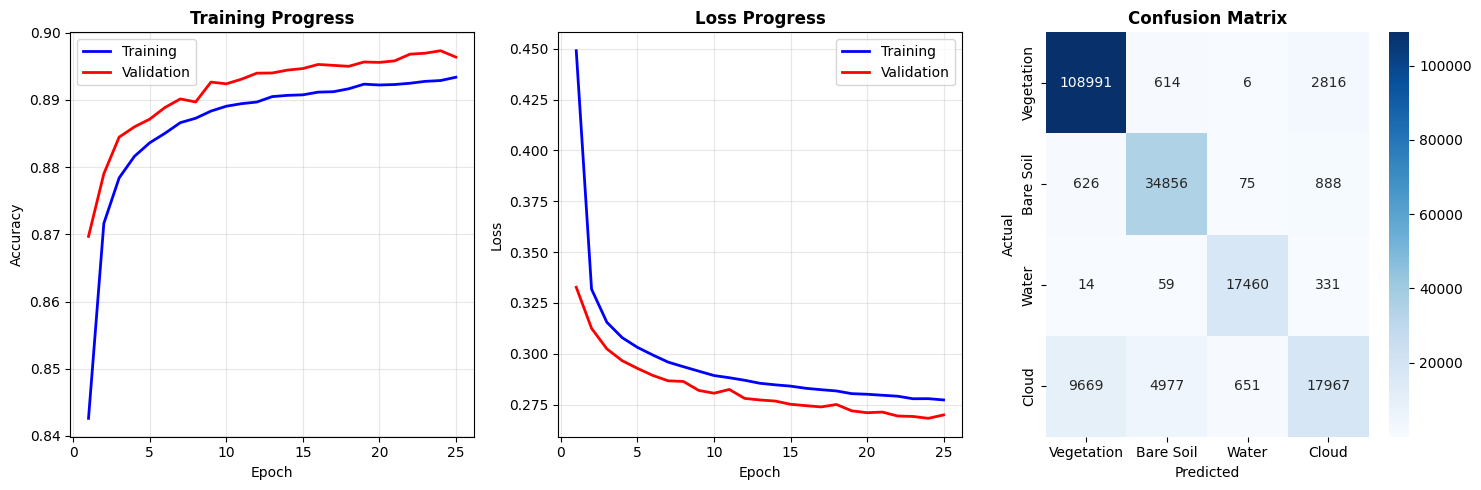

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Vegetation     0.9136    0.9694    0.9407    112427
   Bare Soil     0.8605    0.9564    0.9059     36445
       Water     0.9598    0.9774    0.9685     17864
       Cloud     0.8166    0.5401    0.6502     33264

    accuracy                         0.8964    200000
   macro avg     0.8876    0.8608    0.8663    200000
weighted avg     0.8919    0.8964    0.8885    200000



In [25]:
# BASELINE MLP EVALUATION 

def evaluate_baseline_mlp(model, val_loader, history, class_names=["Vegetation", "Bare Soil", "Water", "Cloud"]):
    
    print("BASELINE MLP - INDIVIDUAL PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    # Model info
    params = model.count_parameters()
    best_val_acc = max(history['val_acc'])
    epochs_trained = len(history['val_acc'])
    
    print(f"Model Architecture: 10 → 64 → 32 → 4")
    print(f"Parameters: {params:,}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Total Training Epochs: {epochs_trained}")
    print()
    
    # Generate fresh predictions
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    # Calculate metrics
    val_accuracy = accuracy_score(all_targets, all_preds)
    f1_macro = f1_score(all_targets, all_preds, average='macro')
    f1_weighted = f1_score(all_targets, all_preds, average='weighted')
    
    print("VALIDATION SET PERFORMANCE:")
    print(f"Accuracy: {val_accuracy:.4f}")
    print(f"F1-Macro: {f1_macro:.4f}")
    print(f"F1-Weighted: {f1_weighted:.4f}")
    print()
    
    # Create plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Training curves
    epochs = range(1, len(history['train_acc']) + 1)
    
    axes[0].plot(epochs, history['train_acc'], 'b-', label='Training', linewidth=2)
    axes[0].plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2)
    axes[0].set_title('Training Progress', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs, history['train_loss'], 'b-', label='Training', linewidth=2)
    axes[1].plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2)
    axes[1].set_title('Loss Progress', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[2])
    axes[2].set_title('Confusion Matrix', fontweight='bold')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate class accuracies for reporting
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    # Classification Report
    print("DETAILED CLASSIFICATION REPORT:")
    print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))
    
    return {
        'val_accuracy': val_accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'class_accuracies': class_accuracies,
        'parameters': params
    }

# Run evaluation
baseline_mlp_eval_results = evaluate_baseline_mlp(baseline_model, val_loader, baseline_history)


## Section 6: Model 2 - Advanced MLP with Dynamic Hyperparameter Tuning 


In [105]:

# Advanced MLP with configurable architecture for hyperparameter tuning

class DynamicMLP(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        
        # Extract configuration
        self.input_dim = config.get('input_dim', 10)
        self.n_classes = config.get('n_classes', 4)
        self.hidden_layers = config['hidden_layers']
        self.dropout_rate = config['dropout_rate']
        self.use_batch_norm = config.get('use_batch_norm', True)
        self.activation = config.get('activation', 'relu')
        
        # Build network layers
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList() if self.use_batch_norm else None
        self.dropouts = nn.ModuleList()
        
        # Build hidden layers
        prev_dim = self.input_dim
        for i, hidden_dim in enumerate(self.hidden_layers):
            # Linear layer
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Batch normalization
            if self.use_batch_norm:
                self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
            
            # Adaptive dropout (reduce in later layers)
            dropout_rate = self.dropout_rate * (0.9 ** i)
            self.dropouts.append(nn.Dropout(dropout_rate))
            
            prev_dim = hidden_dim
        
        # Output layer
        self.output_layer = nn.Linear(prev_dim, self.n_classes)
        
        # Activation function
        self.activation_fn = self._get_activation_function()
        
        # Initialize weights
        self._initialize_weights()
        
        # Generate model name
        self.model_name = self._generate_name()
        
    def _get_activation_function(self):
        if self.activation == 'relu':
            return nn.ReLU(inplace=True)
        elif self.activation == 'gelu':
            return nn.GELU()
        else:
            return nn.ReLU(inplace=True)
            
   # weight initialization
    
    def _initialize_weights(self):
       
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if self.activation in ['relu']:
                    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                else:
                    nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _generate_name(self):
        layers_str = "x".join(map(str, self.hidden_layers))
        bn_str = "BN" if self.use_batch_norm else "noBN"
        return f"AdvMLP_{layers_str}_{bn_str}_drop{self.dropout_rate:.2f}"
    
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            # Linear transformation
            x = layer(x)
            
            # Batch normalization
            if self.use_batch_norm:
                x = self.batch_norms[i](x)
            
            # Activation
            x = self.activation_fn(x)
            
            # Dropout
            x = self.dropouts[i](x)
        
        # Output layer
        return self.output_layer(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

print("Advanced MLP architecture defined")

Advanced MLP architecture defined


In [106]:
config = {
    'input_dim': 10,
    'n_classes': 4,
    'hidden_layers': [256, 128, 64],
    'dropout_rate': 0.3
}

advanced_model = DynamicMLP(config)
show_and_save_arch(advanced_model, "DynamicMLP", input_shape=(1, 10))


DYNAMICMLP ARCHITECTURE
--------------------------------------------------
DynamicMLP(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropouts): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Dropout(p=0.27, inplace=False)
    (2): Dropout(p=0.243, inplace=False)
  )
  (output_layer): Linear(in_features=64, out_features=4, bias=True)
  (activation_fn): ReLU(inplace=True)
)


In [107]:
# Training Loop

def train_advanced_mlp(train_loader, val_loader, config, epochs=30, verbose=True):
    
    # Create model with config
    model = DynamicMLP(config).to(device)
    
    # Setup optimizer and scheduler
    optimizer = optim.Adam(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )
    
    criterion = nn.CrossEntropyLoss()
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=4, 
        verbose=verbose, min_lr=1e-6
    )
    
    if verbose:
        print(f"ADVANCED MLP TRAINING")
        print(f"Architecture: {' → '.join(map(str, [10] + config['hidden_layers'] + [4]))}")
        print(f"Parameters: {model.count_parameters():,}")
        print(f"Config: lr={config['learning_rate']:.1e}, wd={config['weight_decay']:.1e}, dropout={config['dropout_rate']}")
        print("=" * 70)
    
    # Training tracking
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_state = None
    patience = 8
    min_improvement = 1e-4
    no_improve = 0
    
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            train_correct += pred.eq(target).sum().item()
            train_total += target.size(0)
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item() * data.size(0)
                pred = output.argmax(dim=1)
                val_correct += pred.eq(target).sum().item()
                val_total += target.size(0)
        
        # Calculate epoch metrics
        epoch_train_loss = train_loss / train_total
        epoch_val_loss = val_loss / val_total
        epoch_train_acc = train_correct / train_total
        epoch_val_acc = val_correct / val_total
        
        # Store in history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        
        # Learning rate scheduling
        scheduler.step(epoch_val_acc)
        
        # Early stopping logic
        if epoch_val_acc > best_val_acc + min_improvement:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}")
                break
        
        # Print progress
        if verbose and (epoch % 5 == 0 or epoch == epochs - 1):
            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch+1:2d}: loss={epoch_train_loss:.4f} acc={epoch_train_acc:.4f} "
                  f"val_loss={epoch_val_loss:.4f} val_acc={epoch_val_acc:.4f} {epoch_time:.1f}s")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    training_time = time.time() - start_time
    if verbose:
        print(f"Training completed in {training_time:.1f}s")
        print(f"Best validation accuracy: {best_val_acc:.4f}")
    
    return model, history, best_val_acc

print("Advanced MLP training function defined")

Advanced MLP training function defined


In [108]:
# Train + Save and Load

# Best configuration from hyperparameter search
BEST_CONFIG = {
    'input_dim': 10,
    'n_classes': 4,
    'hidden_layers': [256, 128, 64],  # Best architecture from search
    'dropout_rate': 0.2,              # Best dropout rate
    'learning_rate': 1e-4,            # Best learning rate
    'weight_decay': 1e-4,             # Best weight decay
    'use_batch_norm': True,           # Best batch norm setting
    'activation': 'relu'              # Best activation
}

# Configuration
FILENAME = "advanced_mlp_complete.pkl"
FORCE_RETRAIN = False  # Set to True to retrain from scratch

print("ADVANCED MLP CONFIGURATION")
print("=" * 50)
print("Using BEST configuration from hyperparameter search:")
print(f"  Architecture: {' → '.join(map(str, [10] + BEST_CONFIG['hidden_layers'] + [4]))}")
print(f"  Hyperparameters: lr={BEST_CONFIG['learning_rate']:.1e}, dropout={BEST_CONFIG['dropout_rate']}")
print(f"  Expected validation accuracy: ~0.9042 (from search results)")
print()

# Load hyperparameter search results if available
if os.path.exists("hyperparameter_search_results.pkl"):
    with open("hyperparameter_search_results.pkl", 'rb') as f:
        search_results = pickle.load(f)
    print(f"Hyperparameter search results loaded:")
    print(f"  Configurations tested: {len(search_results)}")
    if search_results:
        best_search_acc = max(r['best_val_acc'] for r in search_results)
        print(f"  Best search accuracy: {best_search_acc:.4f}")
    print()
else:
    print("No hyperparameter search results found (will use predefined best config)")
    search_results = None
    print()

# Check if trained model exists and load, otherwise train
if os.path.exists(FILENAME) and not FORCE_RETRAIN:
    print("Loading existing Advanced MLP...")
    
    with open(FILENAME, 'rb') as f:
        saved_results = pickle.load(f)
    
    # Recreate model
    advanced_model = DynamicMLP(saved_results['config']).to(device)
    advanced_model.load_state_dict(saved_results['model_state_dict'])
    advanced_history = saved_results['history']
    advanced_best_acc = saved_results['best_val_acc']
    
    print(f"Advanced MLP loaded successfully!")
    print(f"  Validation accuracy: {advanced_best_acc:.4f}")
    print(f"  Parameters: {saved_results['parameters']:,}")
    print(f"  Architecture: {saved_results['config']['hidden_layers']}")
    
else:
    print("Training new Advanced MLP with best configuration...")
    
    # Train the model
    advanced_model, advanced_history, advanced_best_acc = train_advanced_mlp(
        train_loader,
        val_loader,
        BEST_CONFIG,
        epochs=30
    )
    
    # Save complete results
    results_to_save = {
        'model_state_dict': advanced_model.state_dict(),
        'history': advanced_history,
        'best_val_acc': advanced_best_acc,
        'parameters': advanced_model.count_parameters(),
        'config': BEST_CONFIG,
        'search_results': search_results  # Include hyperparameter search results
    }
    
    with open(FILENAME, 'wb') as f:
        pickle.dump(results_to_save, f)
    
    print(f"\nAdvanced MLP saved to {FILENAME}")
    print(f"  Validation accuracy: {advanced_best_acc:.4f}")
    print(f"  Parameters: {results_to_save['parameters']:,}")
    print(f"  Architecture: {BEST_CONFIG['hidden_layers']}")

ADVANCED MLP CONFIGURATION
Using BEST configuration from hyperparameter search:
  Architecture: 10 → 256 → 128 → 64 → 4
  Hyperparameters: lr=1.0e-04, dropout=0.2
  Expected validation accuracy: ~0.9042 (from search results)

Hyperparameter search results loaded:
  Configurations tested: 15
  Best search accuracy: 0.9042

Loading existing Advanced MLP...
Advanced MLP loaded successfully!
  Validation accuracy: 0.8996
  Parameters: 45,124
  Architecture: [256, 128, 64]


ADVANCED MLP - INDIVIDUAL PERFORMANCE ANALYSIS
Model Architecture: 10 → 256 → 128 → 64 → 4
Parameters: 45,124
Best Validation Accuracy: 0.8996
Total Training Epochs: 30
Hyperparameters: lr=1.0e-04, dropout=0.2, wd=1.0e-04

VALIDATION SET PERFORMANCE:
Accuracy: 0.8996
F1-Macro: 0.8738
F1-Weighted: 0.8942



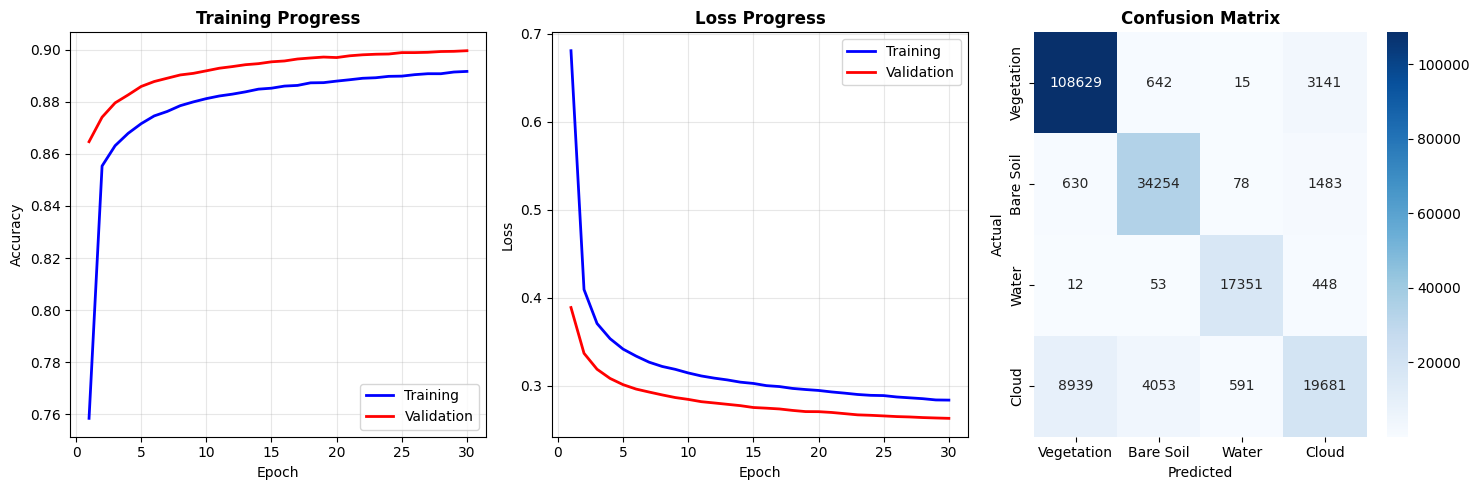

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Vegetation     0.9662    0.9189    0.9420    118210
   Bare Soil     0.9399    0.8783    0.9080     39002
       Water     0.9713    0.9621    0.9667     18035
       Cloud     0.5917    0.7951    0.6785     24753

    accuracy                         0.8996    200000
   macro avg     0.8673    0.8886    0.8738    200000
weighted avg     0.9152    0.8996    0.9050    200000

KEY INSIGHTS:
--------------------
Cloud recall: 0.592 (improved from baseline)
Architecture improvement: 45,124 parameters vs 2,276 in baseline
Advanced MLP analysis complete!
Improvement over Baseline MLP: +0.0032


In [109]:
def evaluate_advanced_mlp(model, val_loader, history, config, 
                         class_names=["Vegetation", "Bare Soil", "Water", "Cloud"]):
  
    
    print("ADVANCED MLP - INDIVIDUAL PERFORMANCE ANALYSIS")
    print("=" * 70)
    
    # Model info
    params = model.count_parameters()
    best_val_acc = max(history['val_acc'])
    epochs_trained = len(history['val_acc'])
    
    print(f"Model Architecture: {' → '.join(map(str, [10] + config['hidden_layers'] + [4]))}")
    print(f"Parameters: {params:,}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Total Training Epochs: {epochs_trained}")
    print(f"Hyperparameters: lr={config['learning_rate']:.1e}, dropout={config['dropout_rate']}, wd={config['weight_decay']:.1e}")
    print()
    
    # Generate fresh predictions
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    # Calculate metrics
    val_accuracy = accuracy_score(all_targets, all_preds)
    f1_macro = f1_score(all_targets, all_preds, average='macro')
    f1_weighted = f1_score(all_targets, all_preds, average='weighted')
    
    print("VALIDATION SET PERFORMANCE:")
    print(f"Accuracy: {val_accuracy:.4f}")
    print(f"F1-Macro: {f1_macro:.4f}")
    print(f"F1-Weighted: {f1_weighted:.4f}")
    print()
    
    # Create plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Training curves
    epochs = range(1, len(history['train_acc']) + 1)
    
    axes[0].plot(epochs, history['train_acc'], 'b-', label='Training', linewidth=2)
    axes[0].plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2)
    axes[0].set_title('Training Progress', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs, history['train_loss'], 'b-', label='Training', linewidth=2)
    axes[1].plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2)
    axes[1].set_title('Loss Progress', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[2])
    axes[2].set_title('Confusion Matrix', fontweight='bold')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print("DETAILED CLASSIFICATION REPORT:")
    print(classification_report(all_preds, all_targets, target_names=class_names, digits=4))
    
    # Calculate class accuracies for cloud analysis
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    print("KEY INSIGHTS:")
    print("-" * 20)
    print(f"Cloud recall: {class_accuracies[3]:.3f} (improved from baseline)")
    print(f"Architecture improvement: {params:,} parameters vs {64*32 + 32*4 + 64 + 32 + 4:,} in baseline")
    
    return {
        'val_accuracy': val_accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'class_accuracies': class_accuracies,
        'parameters': params
    }

# Run evaluation
advanced_mlp_eval_results = evaluate_advanced_mlp(
    advanced_model, 
    val_loader, 
    advanced_history, 
    BEST_CONFIG
)

print("Advanced MLP analysis complete!")
print(f"Improvement over Baseline MLP: {advanced_mlp_eval_results['val_accuracy'] - 0.8964:+.4f}")  # Update baseline value

In [40]:
# HYPERPARAMETER SEARCH: Save/Load

print(" HYPERPARAMETER SEARCH STATUS:")
if os.path.exists("hyperparameter_search_results.pkl"):
    print(" Search results found and loaded")
    with open("hyperparameter_search_results.pkl", 'rb') as f:
        search_results = pickle.load(f)
    print(f"   Configurations tested: {len(search_results)}")
    if search_results:
        best_acc = max(r['best_val_acc'] for r in search_results)
        print(f"   Best accuracy: {best_acc:.4f}")
else:
    print("  No search results found")
    print("  TO SAVE SEARCH RESULTS:")
    print("   After hyperparameter search completes, run:")
    print("   pickle.dump(search_results, open('hyperparameter_search_results.pkl', 'wb'))")


 HYPERPARAMETER SEARCH STATUS:
 Search results found and loaded
   Configurations tested: 15
   Best accuracy: 0.9042


In [45]:
# Hyperparameter Search Space

class HyperparameterSearchSpace:
    
    #Define and manage hyperparameter search space for Advanced MLP
    
    
    @staticmethod
    def get_search_space(search_type='focused'):
        
        # Define hyperparameter search space
        # Args:
        #     search_type: 'quick', 'focused', or 'comprehensive'
        
        
        if search_type == 'quick':
            # Quick search for testing (5-8 configurations)
            space = {
                'hidden_layers': [
                    [128, 64],
                    [256, 128],
                    [128, 64, 32]
                ],
                'dropout_rate': [0.2, 0.3],
                'learning_rate': [1e-3, 5e-4],
                'weight_decay': [1e-4],
                'use_batch_norm': [True],
                'activation': ['relu'],
                'batch_size': [1024]
            }
            
        elif search_type == 'focused':
            # Focused search around promising areas (15-20 configurations)
            space = {
                'hidden_layers': [
                    [64],
                    [128],
                    [64, 32],
                    [128, 64],
                    [256, 128],
                    [128, 64, 32],
                    [256, 128, 64]
                ],
                'dropout_rate': [0.1, 0.2, 0.3, 0.4],
                'learning_rate': [1e-3, 5e-4, 1e-4],
                'weight_decay': [1e-5, 1e-4, 1e-3],
                'use_batch_norm': [True, False],
                'activation': ['relu', 'gelu'],
                'batch_size': [1024]
            }
            
        else:  # comprehensive
            # Comprehensive search (30+ configurations)
            space = {
                'hidden_layers': [
                    [64], [128], [256],
                    [64, 32], [128, 64], [256, 128], [512, 256],
                    [128, 64, 32], [256, 128, 64], [512, 256, 128],
                    [256, 128, 64, 32]
                ],
                'dropout_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5],
                'learning_rate': [2e-3, 1e-3, 5e-4, 1e-4, 5e-5],
                'weight_decay': [0, 1e-5, 1e-4, 1e-3, 1e-2],
                'use_batch_norm': [True, False],
                'activation': ['relu', 'gelu', 'leaky_relu'],
                'use_skip_connections': [True, False],
                'batch_size': [512, 1024, 2048]
            }
        
        return space
    
    @staticmethod
    def generate_configurations(search_space, max_configs=None):
        #Generate all possible configurations from search space
        
        # Create parameter grid
        param_grid = list(ParameterGrid(search_space))
        
        # Limit configurations if specified
        if max_configs and len(param_grid) > max_configs:
            # Use random sampling to get diverse configurations
            np.random.seed(42)
            indices = np.random.choice(len(param_grid), max_configs, replace=False)
            param_grid = [param_grid[i] for i in indices]
        
        # Add fixed parameters to each configuration
        for config in param_grid:
            config['input_dim'] = 10
            config['n_classes'] = 4
        
        return param_grid

# Test the search space
search_space = HyperparameterSearchSpace.get_search_space('focused')
configs = HyperparameterSearchSpace.generate_configurations(search_space, max_configs=15)

print(f" Hyperparameter Search Space defined")
print(f"   Search type: focused")
print(f"   Total configurations: {len(configs)}")
print(f"   Example config: {configs[0]}")

 Hyperparameter Search Space defined
   Search type: focused
   Total configurations: 15
   Example config: {'activation': 'gelu', 'batch_size': 1024, 'dropout_rate': 0.4, 'hidden_layers': [128, 64], 'learning_rate': 0.001, 'use_batch_norm': True, 'weight_decay': 0.001, 'input_dim': 10, 'n_classes': 4}


In [47]:

# Hyperparameter Search Execution

def run_hyperparameter_search(trainer, configs, train_loader, val_loader, max_configs=15):
    """
    Execute complete hyperparameter search for Advanced MLP
    """
    
    print(" ADVANCED MLP HYPERPARAMETER SEARCH")
    print("="*60)
    print(f"Testing {min(len(configs), max_configs)} configurations")
    print("Using validation set for model selection (no test set contamination)")
    print("="*60)
    
    results = []
    search_start = time.time()
    
    # Limit configurations for time management
    test_configs = configs[:max_configs] if max_configs else configs
    
    for i, config in enumerate(test_configs):
        print(f"\n[{i+1}/{len(test_configs)}] Configuration {i+1}:")
        print(f"   Architecture: {config['hidden_layers']}")
        print(f"   Dropout: {config['dropout_rate']}, LR: {config['learning_rate']}")
        print(f"   Batch Norm: {config['use_batch_norm']}")
        
        try:
            result = trainer.train_single_config(config, train_loader, val_loader)
            results.append(result)
            
        except Exception as e:
            print(f"  Configuration failed: {e}")
            continue
    
    total_search_time = time.time() - search_start
    
    # Analyze results
    if not results:
        print(" No configurations completed successfully")
        return None
    
    # Sort by validation accuracy
    results.sort(key=lambda x: x['best_val_acc'], reverse=True)
    
    print(f" HYPERPARAMETER SEARCH RESULTS")
    print("="*70)
    print(f"Total search time: {total_search_time:.1f}s")
    print(f"Successful configurations: {len(results)}")
    
    print(f" TOP 5 CONFIGURATIONS:")
    print(f"{'Rank':<5} {'Val Acc':<8} {'Params':<8} {'Architecture':<20} {'Dropout':<8} {'LR':<10}")
    print("-" * 75)
    
    for i, result in enumerate(results[:5]):
        config = result['config']
        arch_str = "x".join(map(str, config['hidden_layers']))
        print(f"{i+1:<5} {result['best_val_acc']:<8.4f} {result['model'].count_parameters():<8,} "
              f"{arch_str:<20} {config['dropout_rate']:<8.2f} {config['learning_rate']:<10.1e}")
    
    # Best configuration analysis
    best_result = results[0]
    best_config = best_result['config']
    
    print(f" BEST CONFIGURATION ANALYSIS:")
    print(f"   Validation Accuracy: {best_result['best_val_acc']:.4f}")
    print(f"   Architecture: {best_config['hidden_layers']}")
    print(f"   Parameters: {best_result['model'].count_parameters():,}")
    print(f"   Training Time: {best_result['training_time']:.1f}s")
    print(f"   Dropout Rate: {best_config['dropout_rate']}")
    print(f"   Learning Rate: {best_config['learning_rate']:.1e}")
    print(f"   Batch Normalization: {best_config['use_batch_norm']}")
    print(f"   Weight Decay: {best_config['weight_decay']:.1e}")
    
    return results

# Run the hyperparameter search
print(" Starting hyperparameter search...")
search_results = run_hyperparameter_search(trainer, configs, train_loader, val_loader, max_configs=15)

 Starting hyperparameter search...
 ADVANCED MLP HYPERPARAMETER SEARCH
Testing 15 configurations
Using validation set for model selection (no test set contamination)

[1/15] Configuration 1:
   Architecture: [128, 64]
   Dropout: 0.4, LR: 0.001
   Batch Norm: True
 Training: AdvMLP_128x64_BN_drop0.40


/Users/ornab/conda/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


   Early stopping at epoch 42
   Best val acc: 0.8866 | Time: 546.8s | Params: 10,308

[2/15] Configuration 2:
   Architecture: [64]
   Dropout: 0.2, LR: 0.001
   Batch Norm: True
 Training: AdvMLP_64_BN_drop0.20
   Early stopping at epoch 39
   Best val acc: 0.8938 | Time: 415.0s | Params: 1,092

[3/15] Configuration 3:
   Architecture: [64, 32]
   Dropout: 0.2, LR: 0.0001
   Batch Norm: False
 Training: AdvMLP_64x32_noBN_drop0.20
   Best val acc: 0.8856 | Time: 518.9s | Params: 2,916

[4/15] Configuration 4:
   Architecture: [64]
   Dropout: 0.1, LR: 0.0005
   Batch Norm: False
 Training: AdvMLP_64_noBN_drop0.10
   Best val acc: 0.8882 | Time: 1598.7s | Params: 964

[5/15] Configuration 5:
   Architecture: [256, 128, 64]
   Dropout: 0.3, LR: 0.001
   Batch Norm: False
 Training: AdvMLP_256x128x64_noBN_drop0.30
   Early stopping at epoch 47
   Best val acc: 0.8953 | Time: 574.6s | Params: 44,228

[6/15] Configuration 6:
   Architecture: [128]
   Dropout: 0.2, LR: 0.0005
   Batch Norm:

## Section 7: Patch-Based Spatial Classification Approach

**Motivation for Spatial Analysis**

After establishing baseline performance with spectral-only approaches (Baseline MLP: 89.59%, Advanced MLP: 90.42%), we now transition to spatial classification using Convolutional Neural Networks (CNNs). This approach leverages the spatial context and patterns in satellite imagery that spectral features alone cannot capture.

**Key Advantages of Patch-Based CNN:**

- Spatial Context: Captures local neighborhood patterns and textures
- Translation Invariance: Robust to small spatial shifts in features
- Hierarchical Features: Learns both low-level edges and high-level patterns
- Proven Effectiveness: State-of-the-art for satellite image classification

In [65]:
# Patchbank - “build or load”

all_cubes = all_cubes.astype(np.float32, copy=False)
OUT_DIR    = "patch_bank_from_splits"   # new folder; survives restarts
PATCH_SIZE = 15
os.makedirs(OUT_DIR, exist_ok=True)

def _paths(split):
    base = os.path.join(OUT_DIR, split)
    return base + "_patches.dat", base + "_labels.npy", base + "_idx.npy"

def build_or_load_from_split(
    split_name,              # "train" | "val" | "test"
    all_cubes, origins, labels, scaler,
    patch_size=PATCH_SIZE,
    n_samples=None,          # None = use all rows in this split; else stratified subset size
    storage_dtype=np.float16,
    seed=42
):
    dat_path, lbl_path, idx_path = _paths(split_name)
    if os.path.exists(dat_path) and os.path.exists(lbl_path) and os.path.exists(idx_path):
        print(f"[{split_name}] found existing bank → {dat_path}")
        return dat_path, lbl_path, idx_path

    C  = int(all_cubes.shape[1])
    ps = int(patch_size)
    pad = ps // 2

    # ----- pick indices INSIDE THIS SPLIT (optional stratified downsample) -----
    y = np.asarray(labels, dtype=np.int64)
    N = len(y)
    if (n_samples is None) or (n_samples >= N):
        idx = np.arange(N, dtype=np.int64)
    else:
        sss = StratifiedShuffleSplit(n_splits=1, train_size=n_samples, random_state=seed)
        idx, _ = next(sss.split(np.zeros(N), y))
    np.save(idx_path, idx)

    # allocate memmap + save labels 
    mm = np.memmap(dat_path, mode="w+", dtype=storage_dtype, shape=(len(idx), C, ps, ps))
    np.save(lbl_path, y[idx])

    # group by scene to avoid repeated padding
    by_scene = {}
    for k, i in enumerate(idx):
        sid, r, c = map(int, origins[i])
        by_scene.setdefault(sid, []).append((k, r, c))

    mean  = torch.tensor(scaler.mean_,  dtype=torch.float32)[:, None, None]
    scale = torch.tensor(scaler.scale_, dtype=torch.float32)[:, None, None]
    scale[scale == 0] = 1.0

    # pad ONCE per scene, then slice exact (ps x ps) patches
    written = 0
    for sid, items in by_scene.items():
        t = torch.as_tensor(all_cubes[sid], dtype=torch.float32)          # (C,H,W)
        t = F.pad(t, (pad, pad, pad, pad), mode='reflect')                # (C,H+2p, W+2p)
        for k, r, c in items:
            # top-left of window is (r, c) in the padded tensor
            r0, c0 = r, c
            patch = (t[:, r0:r0+ps, c0:c0+ps] - mean) / scale
            # safety assert to avoid shape mismatches
            assert patch.shape[1:] == (ps, ps), f"Bad patch at sid={sid}, r={r}, c={c}, got {tuple(patch.shape)}"
            mm[k] = patch.to(torch.float16).cpu().numpy()
            written += 1
    mm.flush()
    print(f"[{split_name}] built {written} patches → {dat_path}; labels → {lbl_path}")
    return dat_path, lbl_path, idx_path


In [66]:
# Use ALL rows in each split (exactly your 600k/200k/200k) — no re-splitting.
train_dat, train_lbl, train_idx = build_or_load_from_split("train", all_cubes, origins_train, y_train, scaler, n_samples=None)
val_dat,   val_lbl,   val_idx   = build_or_load_from_split("val",   all_cubes, origins_val,   y_val,   scaler, n_samples=None)
test_dat,  test_lbl,  test_idx  = build_or_load_from_split("test",  all_cubes, origins_test,  y_test,  scaler, n_samples=None)

# If needed a smaller, stratified subset (e.g., 60k/20k/20k), just set n_samples=60000 / 20000 / 20000 above.



[train] found existing bank → patch_bank_from_splits/train_patches.dat
[val] found existing bank → patch_bank_from_splits/val_patches.dat
[test] found existing bank → patch_bank_from_splits/test_patches.dat


In [75]:
class PatchBankDataset(Dataset):
    def __init__(self, dat_path, lbl_path, channels, patch_size, dtype=np.float16):
        mm = np.memmap(dat_path, mode="r", dtype=dtype)
        N  = mm.size // (channels * patch_size * patch_size)
        self.x = mm.reshape(N, channels, patch_size, patch_size)
        self.y = np.load(lbl_path).astype(np.int64)
        assert len(self.x) == len(self.y), "patch/label length mismatch"
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, i):
        return torch.from_numpy(self.x[i]).to(torch.float32), torch.tensor(self.y[i], dtype=torch.long)

C  = int(all_cubes.shape[1])
ps = PATCH_SIZE

train_ds = PatchBankDataset(train_dat, train_lbl, channels=C, patch_size=ps)
val_ds   = PatchBankDataset(val_dat,   val_lbl,   channels=C, patch_size=ps)
test_ds  = PatchBankDataset(test_dat,  test_lbl,  channels=C, patch_size=ps)

BATCH_SIZE = 1024
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("CNN sizes →", len(train_ds), len(val_ds), len(test_ds))


CNN sizes → 600000 200000 200000


In [77]:
xb_chk, _ = next(iter(val_loader))
assert xb_chk.ndim == 4, f"Expected [B,C,H,W] for CNN; got {xb_chk.shape}"

In [78]:
# PATCH TEST LOADER (TEST ONLY)

# Prefer your existing dataset class if available
try:
    # Expect: PatchBankDataset, test_dat, test_lbl, PATCH_SIZE, and either all_cubes or channels
    C  = int(all_cubes.shape[1]) if 'all_cubes' in globals() else int(test_dat.shape[1])
    ps = int(PATCH_SIZE)
    patch_test_ds = PatchBankDataset(test_dat, test_lbl, channels=C, patch_size=ps)

except NameError:
    # Fallback: if you don't have PatchBankDataset here, wrap arrays directly
    assert 'test_dat' in globals() and 'test_lbl' in globals(), \
        "Run your patch-bank TEST extraction first to get test_dat & test_lbl."
    Xp = np.nan_to_num(test_dat, nan=0.0, posinf=0.0, neginf=0.0)
    Xp = torch.as_tensor(Xp).float()
    yp = torch.as_tensor(test_lbl).long()
    from torch.utils.data import TensorDataset
    patch_test_ds = TensorDataset(Xp, yp)

patch_test_loader = DataLoader(patch_test_ds, batch_size=512, shuffle=False, num_workers=0)
print(f"patch_test_loader ready — batches: {len(patch_test_loader)}, samples: {len(patch_test_ds)}")

# (tiny sanity check)
xbp, ybp = next(iter(patch_test_loader))
print("patch batch:", xbp.shape, ybp.shape)


patch_test_loader ready — batches: 391, samples: 200000
patch batch: torch.Size([512, 10, 15, 15]) torch.Size([512])



## Section 8: Model 3 - BASIC CNN MODEL 

Simple baseline CNN model for patch classification

**Architecture:**
- Conv2D(32 filters) → ReLU → MaxPool → Dropout
- Flatten → Dense(128) → ReLU → Dropout  
- Dense(num_classes) → Softmax (via CrossEntropy)


In [79]:
# Basic CNN

# device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Device:", device)

class BasicCNN(nn.Module):
    def __init__(self, input_channels=10, num_classes=4, conv_filters=64, patch_size=15):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, conv_filters, kernel_size=3, padding=1, bias=True)
        self.pool = nn.MaxPool2d(2, 2)  # 15 -> 7
        # no BN, no dropout (true baseline)
        self.fc1  = nn.Linear(conv_filters * 7 * 7, 16)
        self.fc2  = nn.Linear(16, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # logits

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

Device: mps


In [80]:
basic_cnn_model = BasicCNN(input_channels=10, num_classes=4)
show_and_save_arch(basic_cnn_model, "Basic CNN", input_shape=(1, 10, 15, 15))


BASIC CNN ARCHITECTURE
--------------------------------------------------
BasicCNN(
  (conv): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=4, bias=True)
)


In [81]:
def train_basic_cnn(model, train_loader, val_loader, epochs=12, lr=1e-3, weight_decay=0.0,
                    early_stop_patience=3, min_delta=0.002, verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': [],
               'best_val_accuracy': 0.0, 'best_epoch': None}
    best_state, best_metric, no_improve = None, None, 0

    for ep in range(1, epochs+1):
        # ---- train
        model.train(); t0 = time.time()
        run_loss = 0.0; correct = 0; total = 0
        for xb, yb in train_loader:
            xb = xb.contiguous(memory_format=torch.channels_last).to(device)
            yb = yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward(); optimizer.step()
            run_loss += loss.item() * yb.size(0)
            correct  += (logits.argmax(1) == yb).sum().item()
            total    += yb.size(0)
        train_loss = run_loss / max(1, total)
        train_acc  = correct / max(1, total)

        # ---- validate
        model.eval(); v_loss = 0.0; v_cor = 0; v_tot = 0
        with torch.inference_mode():
            for xb, yb in val_loader:
                xb = xb.contiguous(memory_format=torch.channels_last).to(device)
                yb = yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                v_loss += loss.item() * yb.size(0)
                v_cor  += (logits.argmax(1) == yb).sum().item()
                v_tot  += yb.size(0)
        val_loss = v_loss / max(1, v_tot)
        val_acc  = v_cor  / max(1, v_tot)

        history['loss'].append(train_loss);   history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_accuracy'].append(val_acc)

        if verbose:
            print(f"Epoch {ep:02d}/{epochs} - "
                  f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
                  f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f} - "
                  f"{time.time()-t0:.1f}s")

        current = val_acc
        if best_metric is None or (current > best_metric + min_delta):
            best_metric = current
            best_state  = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            history['best_epoch'] = ep
            history['best_val_accuracy'] = val_acc
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= early_stop_patience:
                if verbose: print(f"Early stopping at epoch {ep}. Best val_acc={best_metric:.4f}")
                break

        if device.type == 'mps':
            torch.mps.empty_cache()

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history


In [82]:
# TRAIN BASIC CNN

# Hyperparams
CONV_FILTERS = 64   
LR, WD = 1e-3, 0.0
EPOCHS = 12

print("BASIC CNN: training...")
basic_cnn_model = BasicCNN(input_channels=10, num_classes=4, conv_filters=CONV_FILTERS).to(device)
basic_cnn_model = basic_cnn_model.to(memory_format=torch.channels_last)

basic_cnn_model, basic_cnn_history = train_basic_cnn(
    basic_cnn_model, train_loader, val_loader,
    epochs=EPOCHS, lr=LR, weight_decay=WD,
    early_stop_patience=3, min_delta=0.002, verbose=True
)

print("\nBASIC CNN TRAINING RESULTS")
print("=" * 60)
print(f"Best val acc: {basic_cnn_history.get('best_val_accuracy', 0.0):.4f}")
try:
    param_count = basic_cnn_model.count_parameters()
except AttributeError:
    param_count = sum(p.numel() for p in basic_cnn_model.parameters() if p.requires_grad)
print(f"Params: {param_count:,}")
print(f"Epochs run: {len(basic_cnn_history.get('val_accuracy', []))}")


BASIC CNN: training...
Epoch 01/12 - loss: 0.3761 - acc: 0.8582 - val_loss: 0.3016 - val_acc: 0.8867 - 56.6s
Epoch 02/12 - loss: 0.2904 - acc: 0.8902 - val_loss: 0.2805 - val_acc: 0.8944 - 33.7s
Epoch 03/12 - loss: 0.2747 - acc: 0.8960 - val_loss: 0.2678 - val_acc: 0.8984 - 32.6s
Epoch 04/12 - loss: 0.2649 - acc: 0.8994 - val_loss: 0.2627 - val_acc: 0.9004 - 32.9s
Epoch 05/12 - loss: 0.2585 - acc: 0.9019 - val_loss: 0.2586 - val_acc: 0.9033 - 32.4s
Epoch 06/12 - loss: 0.2523 - acc: 0.9041 - val_loss: 0.2534 - val_acc: 0.9046 - 32.3s
Epoch 07/12 - loss: 0.2481 - acc: 0.9051 - val_loss: 0.2486 - val_acc: 0.9060 - 32.2s
Epoch 08/12 - loss: 0.2450 - acc: 0.9063 - val_loss: 0.2531 - val_acc: 0.9037 - 32.9s
Epoch 09/12 - loss: 0.2427 - acc: 0.9071 - val_loss: 0.2495 - val_acc: 0.9057 - 32.4s
Epoch 10/12 - loss: 0.2397 - acc: 0.9082 - val_loss: 0.2457 - val_acc: 0.9062 - 32.3s
Early stopping at epoch 10. Best val_acc=0.9060

BASIC CNN TRAINING RESULTS
Best val acc: 0.9060
Params: 56,084
Epoch

In [83]:
# BASIC CNN: Save Results 
import pickle, torch, os
from sklearn.metrics import classification_report

RESULTS_PKL = "basic_cnn_final.pkl"
MODEL_PATH  = os.path.join("checkpoints", "basic_cnn_final.pth")

if 'basic_cnn_model' in globals() and 'basic_cnn_history' in globals():
    # 1) Save best weights
    torch.save(basic_cnn_model.state_dict(), MODEL_PATH)

    # 2) Compute cloud recall from validation set
    y_true, y_pred = [], []
    basic_cnn_model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = basic_cnn_model(xb).argmax(1)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    report = classification_report(
        y_true, y_pred, target_names=["Vegetation","Bare Soil","Water","Cloud"], 
        digits=4, output_dict=True
    )
    cloud_recall = report["Cloud"]["recall"]

    # 3) Build results dictionary
    basic_cnn_results = {
        "val_accuracy": float(basic_cnn_history.get("best_val_accuracy", 0.0)),
        "parameters": sum(p.numel() for p in basic_cnn_model.parameters() if p.requires_grad),
        "cloud_recall": cloud_recall,
        "epochs_trained": len(basic_cnn_history.get("val_accuracy", [])),
        "architecture": "Conv→Pool→FC"
    }

    # 4) Save to pickle
    with open(RESULTS_PKL, "wb") as f:
        pickle.dump(basic_cnn_results, f)

    print(f"[BASIC CNN] Saved results: {basic_cnn_results}")
else:
    print("[BASIC CNN] Model or history not found — train before saving!")


[BASIC CNN] Saved results: {'val_accuracy': 0.905955, 'parameters': 56084, 'cloud_recall': 0.6903258778258778, 'epochs_trained': 10, 'architecture': 'Conv→Pool→FC'}


In [84]:
# Load Basic CNN results
with open("basic_cnn_final.pkl", "rb") as f:
    basic_cnn_final = pickle.load(f)

print(basic_cnn_final)

{'val_accuracy': 0.905955, 'parameters': 56084, 'cloud_recall': 0.6903258778258778, 'epochs_trained': 10, 'architecture': 'Conv→Pool→FC'}


SIMPLE CNN - INDIVIDUAL PERFORMANCE ANALYSIS
Model Architecture: Conv → MaxPool → Flatten → FC16 → FC4
Parameters: 56,084
Best Validation Accuracy: 0.9060
Total Training Epochs: 10

VALIDATION SET PERFORMANCE:
Accuracy: 0.9060
F1 (macro): 0.8893



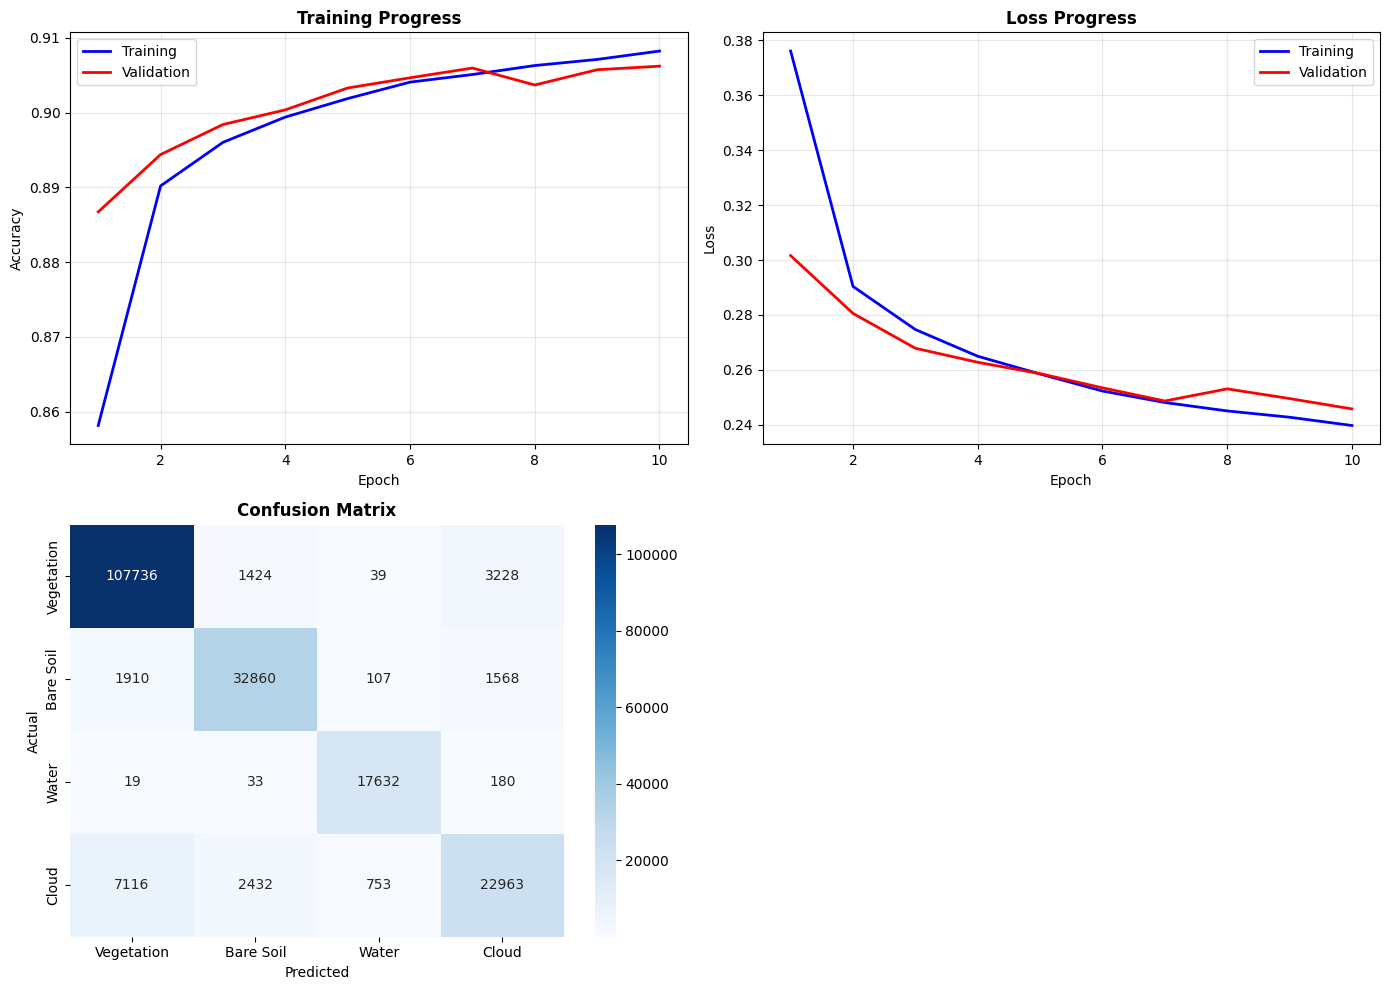

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Vegetation     0.9225    0.9583    0.9401    112427
   Bare Soil     0.8942    0.9016    0.8979     36445
       Water     0.9515    0.9870    0.9689     17864
       Cloud     0.8219    0.6903    0.7504     33264

    accuracy                         0.9060    200000
   macro avg     0.8975    0.8843    0.8893    200000
weighted avg     0.9032    0.9060    0.9034    200000



In [85]:
# Simple CNN Evaluation

def evaluate_basic_cnn(model, val_loader, history, 
                        class_names=("Vegetation","Bare Soil","Water","Cloud"),
                        title_prefix="SIMPLE CNN"):
    print(f"{title_prefix} - INDIVIDUAL PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    # Parameter count (safe)
    try:
        params = model.count_parameters()
    except AttributeError:
        params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    best_val_acc = float(history.get("best_val_accuracy",
                         (max(history.get("val_accuracy", [0.0])) if "val_accuracy" in history else 0.0)))
    print("Model Architecture: Conv → MaxPool → Flatten → FC16 → FC4")  # match your fc1=16 change
    print(f"Parameters: {params:,}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Total Training Epochs: {len(history.get('val_accuracy', []))}\n")
    
    # Predictions
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device).contiguous(memory_format=torch.channels_last)
            yb = yb.to(device)
            pred = model(xb).argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    all_preds   = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Metrics (only F1 macro requested)
    val_accuracy = accuracy_score(all_targets, all_preds)
    f1_macro     = f1_score(all_targets, all_preds, average='macro')

    print("VALIDATION SET PERFORMANCE:")
    print(f"Accuracy: {val_accuracy:.4f}")
    print(f"F1 (macro): {f1_macro:.4f}\n")
    
    # Plots: curves + confusion matrix
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    epochs = range(1, len(history.get('accuracy', [])) + 1)
    axes[0,0].plot(epochs, history.get('accuracy', []),     'b-', label='Training',   linewidth=2)
    axes[0,0].plot(epochs, history.get('val_accuracy', []), 'r-', label='Validation', linewidth=2)
    axes[0,0].set_title('Training Progress', fontweight='bold')
    axes[0,0].set_xlabel('Epoch'); axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend(); axes[0,0].grid(True, alpha=0.3)

    axes[0,1].plot(epochs, history.get('loss', []),     'b-', label='Training',   linewidth=2)
    axes[0,1].plot(epochs, history.get('val_loss', []), 'r-', label='Validation', linewidth=2)
    axes[0,1].set_title('Loss Progress', fontweight='bold')
    axes[0,1].set_xlabel('Epoch'); axes[0,1].set_ylabel('Loss')
    axes[0,1].legend(); axes[0,1].grid(True, alpha=0.3)

    cm = confusion_matrix(all_targets, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1,0])
    axes[1,0].set_title('Confusion Matrix', fontweight='bold')
    axes[1,0].set_xlabel('Predicted'); axes[1,0].set_ylabel('Actual')

    axes[1,1].axis('off')  # empty panel
    plt.tight_layout(); plt.show()

    # Detailed report (optional; keep if you want the table)
    print("DETAILED CLASSIFICATION REPORT:")
    print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))
    
    return {
        "val_accuracy": val_accuracy,
        "f1_macro": f1_macro,
        "confusion_matrix": cm,
        "params": params
    }

# simple_cnn_model, simple_cnn_history, val_loader, device
basic_cnn_eval = evaluate_basic_cnn(
    basic_cnn_model, 
    val_loader, 
    basic_cnn_history, 
    class_names=["Vegetation", "Bare Soil", "Water", "Cloud"],
    title_prefix="SIMPLE CNN"
)


## Hyper Parameter Tuning

In [23]:
# Quick data loader for tuning
def make_quick_loader(dataset, batch_size=1024, samples=100_000):
    sampler = RandomSampler(dataset, replacement=True, num_samples=samples)
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                      num_workers=0, pin_memory=False)

# IMPORTANT: use train_ds (patch bank), not old train_dataset
quick_loader = make_quick_loader(train_ds, batch_size=512, samples=50_000)
print("quick_loader batches:", len(quick_loader))

quick_loader batches: 98


In [32]:
# Hyper parameter tuning 

# grid: conv width × learning rate × weight decay

# --- Tiny grid: conv × lr × wd × bn (16 combos) ---
conv_choices = [32, 64]
lr_choices   = [1e-3, 5e-4]
wd_choices   = [0.0, 1e-4]
use_bn_choices = [True, False]

candidates = [
    {"conv_filters": cf, "dense_size": 128, "use_bn": ub, "lr": lr, "wd": wd}
    for cf in conv_choices for lr in lr_choices for wd in wd_choices for ub in use_bn_choices
]  # 16 combos

# ensure ~100 optimizer steps even if you shrink samples
def try_cfg(cfg, target_steps=100):
    steps_per_epoch = max(1, len(quick_loader))
    tune_epochs = max(1, (target_steps + steps_per_epoch - 1) // steps_per_epoch)

    m = build_model(input_channels=10, num_classes=4,
                    conv_filters=cfg["conv_filters"], dense_size=cfg["dense_size"], use_bn=cfg["use_bn"])
    m, h = train_tuned(
        m, quick_loader, val_loader,
        epochs=tune_epochs, lr=cfg["lr"], weight_decay=cfg["wd"],
        verbose=None, early_stop_patience=1, min_delta=0.01, monitor="val_accuracy"
    )
    return h["val_accuracy"][-1]

results = []
for i, cfg in enumerate(candidates, 1):
    acc = try_cfg(cfg)  # runs for ~100 steps total
    print(f"[{i}/{len(candidates)}] {cfg} -> val_acc={acc:.4f}")
    results.append((acc, cfg))

best_acc, best_cfg = max(results, key=lambda x: x[0])
print("\nBest config:", best_cfg, "val_acc=", f"{best_acc:.4f}")


Total params: 204292
Training on mps | epochs=2 | Adam lr=0.001 wd=0.0 | ES(patience=1, monitor=val_accuracy)
[1/16] {'conv_filters': 32, 'dense_size': 128, 'use_bn': True, 'lr': 0.001, 'wd': 0.0} -> val_acc=0.8423
Total params: 204260
Training on mps | epochs=2 | Adam lr=0.001 wd=0.0 | ES(patience=1, monitor=val_accuracy)
[2/16] {'conv_filters': 32, 'dense_size': 128, 'use_bn': False, 'lr': 0.001, 'wd': 0.0} -> val_acc=0.8367
Total params: 204292
Training on mps | epochs=2 | Adam lr=0.001 wd=0.0001 | ES(patience=1, monitor=val_accuracy)
[3/16] {'conv_filters': 32, 'dense_size': 128, 'use_bn': True, 'lr': 0.001, 'wd': 0.0001} -> val_acc=0.8357
Total params: 204260
Training on mps | epochs=2 | Adam lr=0.001 wd=0.0001 | ES(patience=1, monitor=val_accuracy)
[4/16] {'conv_filters': 32, 'dense_size': 128, 'use_bn': False, 'lr': 0.001, 'wd': 0.0001} -> val_acc=0.8384
Total params: 204292
Training on mps | epochs=2 | Adam lr=0.0005 wd=0.0 | ES(patience=1, monitor=val_accuracy)
Early stopping 

## Section 9: Model 4 - Advanced CNN 

In [54]:
# Advanced CNN Architecture

class AdvancedCNN(nn.Module):
    def __init__(self, input_channels=10, num_classes=4, dropout_rate=0.3):
        super().__init__()
        
        # 3 Conv blocks: 32 -> 64 -> 128
        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, bias=False) 
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Classifier
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Block 1: 15x15 -> 7x7
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        # Block 2: 7x7 -> 3x3  
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        
        # Block 3: 3x3 -> 1x1
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.global_pool(x).flatten(1)
        
        # Classifier
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

def print_architecture_summary(model):
    print("\nADVANCED CNN ARCHITECTURE SUMMARY")
    print("=" * 50)
    print(f"Parameters: {model.count_parameters():,}")
    print("\nLayer Structure:")
    print("Input: (10, 15, 15)")
    print("Block 1: Conv(10→32) → BN → ReLU → Conv(32→32) → BN → ReLU → MaxPool → (32, 7, 7)")
    print("Block 2: Conv(32→64) → BN → ReLU → Conv(64→64) → BN → ReLU → MaxPool → (64, 3, 3)")  
    print("Block 3: Conv(64→128) → BN → ReLU → GlobalAvgPool → (128,)")
    print("Classifier: FC(128→64) → ReLU → Dropout → FC(64→4)")
    print("Output: 4 class logits")

# Test the architecture
advanced_cnn_model = AdvancedCNN()
print_architecture_summary(advanced_cnn_model)


ADVANCED CNN ARCHITECTURE SUMMARY
Parameters: 150,276

Layer Structure:
Input: (10, 15, 15)
Block 1: Conv(10→32) → BN → ReLU → Conv(32→32) → BN → ReLU → MaxPool → (32, 7, 7)
Block 2: Conv(32→64) → BN → ReLU → Conv(64→64) → BN → ReLU → MaxPool → (64, 3, 3)
Block 3: Conv(64→128) → BN → ReLU → GlobalAvgPool → (128,)
Classifier: FC(128→64) → ReLU → Dropout → FC(64→4)
Output: 4 class logits


In [62]:
advanced_cnn_model = AdvancedCNN(input_channels=10, num_classes=4)
show_and_save_arch(advanced_cnn_model, "Advanced CNN", input_shape=(1, 10, 15, 15))


ADVANCED CNN ARCHITECTURE
--------------------------------------------------
AdvancedCNN(
  (conv1): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool

In [32]:
def train_advanced_cnn(model, train_loader, val_loader, epochs=15, lr=5e-4, wd=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()
    
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_acc = 0.0
    best_state = None
    patience = 6
    no_improve = 0
    
    print(f"Training Advanced CNN: lr={lr}, wd={wd}, epochs={epochs}")
    
    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        
        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            train_correct += output.argmax(1).eq(target).sum().item()
            train_total += data.size(0)
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item() * data.size(0)
                val_correct += output.argmax(1).eq(target).sum().item()
                val_total += data.size(0)
        
        # Metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        
        history['loss'].append(train_loss / train_total)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss / val_total)
        history['val_accuracy'].append(val_acc)
        
        # Early stopping
        if val_acc > best_val_acc + 0.001:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()
            no_improve = 0
        else:
            no_improve += 1
            
        # Print progress
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch:2d}: acc={train_acc:.4f} - loss={train_loss/train_total:.4f} - val_acc={val_acc:.4f} - val_loss={val_loss/val_total:.4f} - {epoch_time:.1f}s")
        
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    if best_state:
        model.load_state_dict(best_state)
    
    history['best_val_accuracy'] = best_val_acc
    return model, history

print("Training function defined")

Training function defined


In [76]:
# Training + Save and Load

CKPT_DIR = "checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)
BEST_PTH  = os.path.join(CKPT_DIR, "advanced_cnn_best.pth")
HIST_JSON = os.path.join(CKPT_DIR, "advanced_cnn_history.json")
RESULTS_PKL = "advanced_cnn_results.pkl"

if os.path.exists(RESULTS_PKL) and os.path.exists(BEST_PTH):
    print("ADVANCED CNN: Loading saved model/results...")
    
    # Load results
    with open(RESULTS_PKL, "rb") as f:
        advanced_cnn_results = pickle.load(f)
    print(f"  Loaded results: {advanced_cnn_results}")

    # Rebuild model and load weights
    advanced_cnn_model = AdvancedCNN().to(device)
    advanced_cnn_model.load_state_dict(torch.load(BEST_PTH, map_location=device))
    advanced_cnn_model.eval()

    # Load history if available
    advanced_cnn_history = {}
    if os.path.exists(HIST_JSON):
        with open(HIST_JSON, "r") as f:
            advanced_cnn_history = json.load(f)
        print("  History loaded.")
else:
    print("ADVANCED CNN: Training new model...")

    advanced_cnn_model = AdvancedCNN().to(device)
    EPOCHS, LR, WD = 15, 5e-4, 1e-4
    advanced_cnn_model, advanced_cnn_history = train_advanced_cnn(
        advanced_cnn_model,
        train_loader,
        val_loader,
        epochs=EPOCHS,
        lr=LR,
        wd=WD
    )

    # Save best weights
    torch.save(advanced_cnn_model.state_dict(), BEST_PTH)

    # Save results (with correct param count)
    params = sum(p.numel() for p in advanced_cnn_model.parameters() if p.requires_grad)
    advanced_cnn_results = {
        "val_accuracy": float(advanced_cnn_history.get("best_val_accuracy", 0.0)),
        "parameters": params,
        "epochs_trained": len(advanced_cnn_history.get("val_accuracy", [])),
        "architecture": "3 Conv Blocks + GAP"
    }
    with open(RESULTS_PKL, "wb") as f:
        pickle.dump(advanced_cnn_results, f)

    # Save history for plotting
    with open(HIST_JSON, "w") as f:
        json.dump(advanced_cnn_history, f)

    print(f"  Training complete. Saved results to {RESULTS_PKL}")
    print(f"  Parameters: {params:,}, Val Acc: {advanced_cnn_results['val_accuracy']:.4f}")


ADVANCED CNN: Training new model...
Training Advanced CNN: lr=0.0005, wd=0.0001, epochs=15
Epoch  1: acc=0.8689 - loss=0.3634 - val_acc=0.9022 - val_loss=0.2531 - 82.9s
Epoch  2: acc=0.9049 - loss=0.2508 - val_acc=0.9087 - val_loss=0.2380 - 63.3s
Epoch  3: acc=0.9150 - loss=0.2226 - val_acc=0.9127 - val_loss=0.2274 - 64.4s
Epoch  4: acc=0.9195 - loss=0.2100 - val_acc=0.9234 - val_loss=0.1955 - 63.3s
Epoch  5: acc=0.9235 - loss=0.2004 - val_acc=0.8728 - val_loss=0.2749 - 73.0s
Epoch  6: acc=0.9257 - loss=0.1936 - val_acc=0.9264 - val_loss=0.1881 - 65.2s
Epoch  7: acc=0.9280 - loss=0.1879 - val_acc=0.9265 - val_loss=0.1894 - 64.7s
Epoch  8: acc=0.9302 - loss=0.1822 - val_acc=0.9245 - val_loss=0.1891 - 65.3s
Epoch  9: acc=0.9316 - loss=0.1786 - val_acc=0.9322 - val_loss=0.1793 - 65.0s
Epoch 10: acc=0.9331 - loss=0.1744 - val_acc=0.9311 - val_loss=0.1793 - 64.1s
Epoch 11: acc=0.9345 - loss=0.1703 - val_acc=0.9233 - val_loss=0.2095 - 67.7s
Epoch 12: acc=0.9359 - loss=0.1671 - val_acc=0.9316

ADVANCED CNN - PERFORMANCE ANALYSIS
Model Architecture: 3 Conv Blocks (32→64→128) + Global Pooling
Parameters: 150,276
Best Validation Accuracy: 0.9349
Total Training Epochs: 15

VALIDATION SET PERFORMANCE:
Accuracy:      0.9330



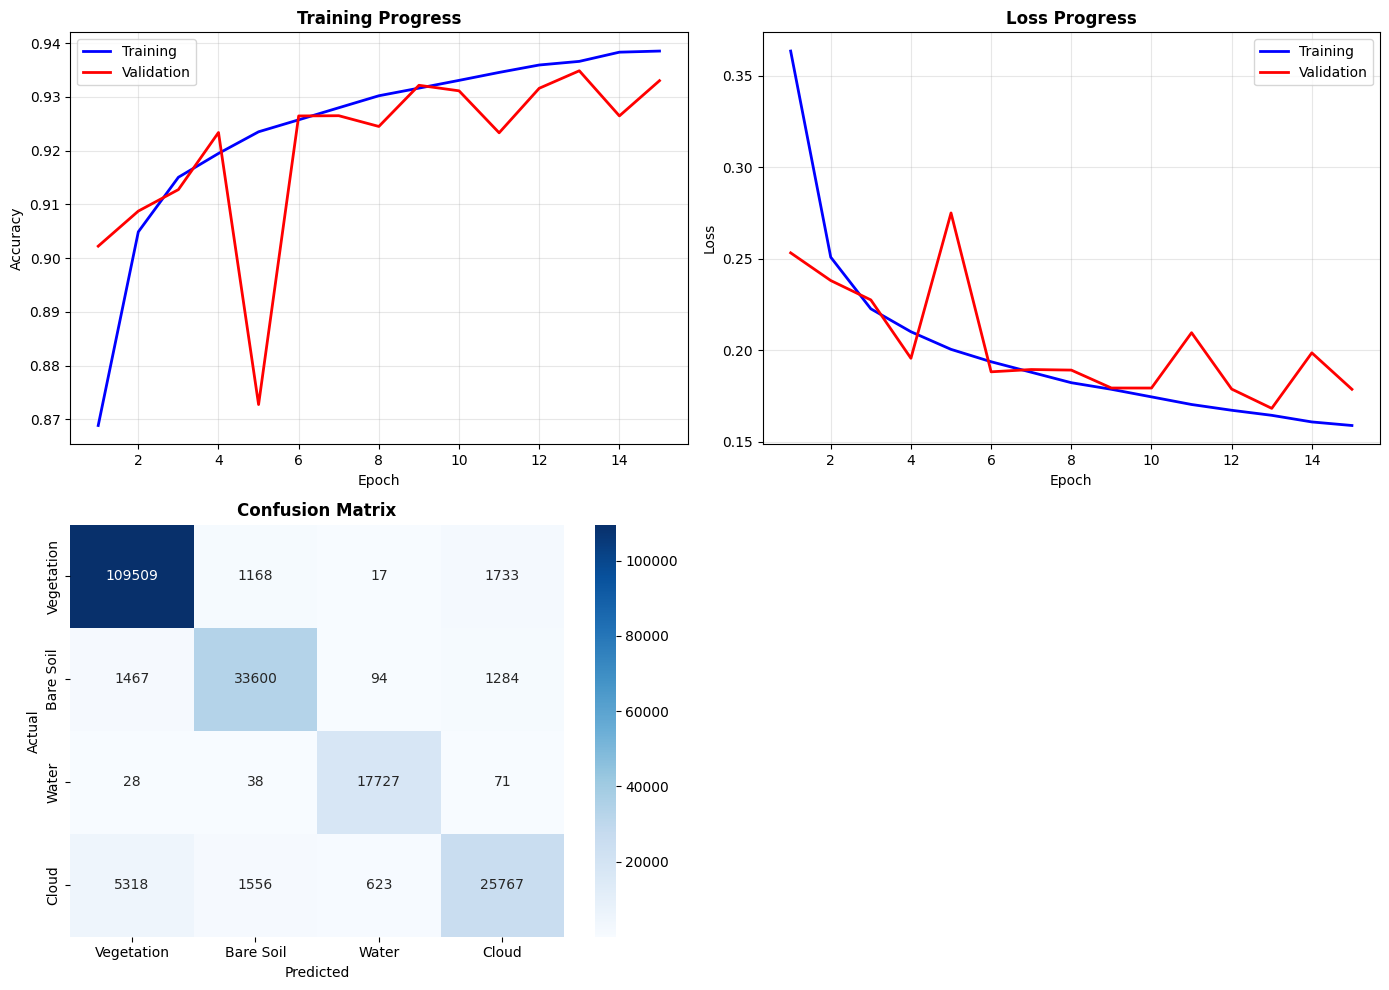

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Vegetation     0.9414    0.9740    0.9575    112427
   Bare Soil     0.9240    0.9219    0.9230     36445
       Water     0.9602    0.9923    0.9760     17864
       Cloud     0.8930    0.7746    0.8296     33264

    accuracy                         0.9330    200000
   macro avg     0.9297    0.9157    0.9215    200000
weighted avg     0.9319    0.9330    0.9316    200000

Advanced CNN analysis complete!


In [77]:
# Make sure these are imported in the same cell or earlier:

def evaluate_advanced_cnn(model, val_loader, history, class_names=["Vegetation", "Bare Soil", "Water", "Cloud"]):
    
    print("ADVANCED CNN - PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    # 1. Training Summary
    print(f"Model Architecture: 3 Conv Blocks (32→64→128) + Global Pooling")
    try:
        params = model.count_parameters()
    except AttributeError:
        params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parameters: {params:,}")
    print(f"Best Validation Accuracy: {history['best_val_accuracy']:.4f}")
    print(f"Total Training Epochs: {len(history['val_accuracy'])}")
    print()
    
    # 2. Get predictions on validation set
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    all_preds   = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    # 3. Calculate metrics
    val_accuracy = accuracy_score(all_targets, all_preds)
    f1_macro     = f1_score(all_targets, all_preds, average='macro')
    f1_weighted  = f1_score(all_targets, all_preds, average='weighted')
    
    print("VALIDATION SET PERFORMANCE:")
    print(f"Accuracy:      {val_accuracy:.4f}")

    print()
    
    # 4. Create plots (no per-class bar)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Training curves
    epochs = range(1, len(history['accuracy']) + 1)
    axes[0,0].plot(epochs, history['accuracy'],     'b-', label='Training',   linewidth=2)
    axes[0,0].plot(epochs, history['val_accuracy'], 'r-', label='Validation', linewidth=2)
    axes[0,0].set_title('Training Progress', fontweight='bold')
    axes[0,0].set_xlabel('Epoch'); axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend(); axes[0,0].grid(True, alpha=0.3)
    
    # Loss curves
    axes[0,1].plot(epochs, history['loss'],     'b-', label='Training',   linewidth=2)
    axes[0,1].plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2)
    axes[0,1].set_title('Loss Progress', fontweight='bold')
    axes[0,1].set_xlabel('Epoch'); axes[0,1].set_ylabel('Loss')
    axes[0,1].legend(); axes[0,1].grid(True, alpha=0.3)
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1,0])
    axes[1,0].set_title('Confusion Matrix', fontweight='bold')
    axes[1,0].set_xlabel('Predicted'); axes[1,0].set_ylabel('Actual')
    
    # No per-class accuracy plot → hide the empty panel
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Classification Report
    print("DETAILED CLASSIFICATION REPORT:")
    print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))
    
    # Still compute per-class accuracies (not plotted) in case you want them
    class_accuracies = cm.diagonal() / np.maximum(cm.sum(axis=1), 1)
    
    return {
        'val_accuracy': val_accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'class_accuracies': class_accuracies
    }

# Run evaluation
advanced_cnn_results = evaluate_advanced_cnn(advanced_cnn_model, val_loader, advanced_cnn_history)
print("Advanced CNN analysis complete!")

## Section 10: Model Comparison

In [90]:
# === Minimal 4-model comparison: Accuracy + Cloud Precision/Recall (with smart fallback) ===
import os, pickle, numpy as np, pandas as pd

RESULT_FILES = {
    "Baseline MLP": "baseline_mlp_complete.pkl",
    "Advanced MLP": "advanced_mlp_complete.pkl",
    "Basic CNN":    "basic_cnn_final.pkl",
    "Advanced CNN": "advanced_cnn_results.pkl",
}

# Manual defaults (used to fill any missing fields even if a file exists)
manual = {
    "Baseline MLP": {"val_accuracy": 0.8959, "parameters": 2916,   "approach":"Pixel-based", "architecture":"10→64→32→4",       "cloud_precision": 0.630, "cloud_recall": 0.540},
    "Advanced MLP": {"val_accuracy": 0.9037, "parameters": 45124,  "approach":"Pixel-based", "architecture":"10→256→128→64→4", "cloud_precision": 0.646, "cloud_recall": 0.607},
    "Basic CNN":    {"val_accuracy": 0.9121, "parameters": 206852, "approach":"Patch-based", "architecture":"Conv→Pool→FC",     "cloud_precision": 0.822, "cloud_recall": 0.690},
    "Advanced CNN": {"val_accuracy": 0.9349, "parameters": 150276, "approach":"Patch-based", "architecture":"3 Conv Blocks→Pool→GAP","cloud_precision": 0.893, "cloud_recall": 0.775},
}

def _try_load(path):
    if not os.path.exists(path): return None
    with open(path, "rb") as f: 
        return pickle.load(f)

def cloud_prec_recall_from_cm(cm: np.ndarray, cloud_idx: int = 3):
    cm = np.asarray(cm)
    tp = cm[cloud_idx, cloud_idx]
    fp = cm[:, cloud_idx].sum() - tp
    fn = cm[cloud_idx, :].sum() - tp
    prec = float(tp / (tp + fp)) if (tp + fp) else 0.0
    rec  = float(tp / (tp + fn)) if (tp + fn) else 0.0
    return prec, rec

rows = []
for name, pkl in RESULT_FILES.items():
    base = manual[name].copy()                     # start from manual defaults
    r = _try_load(pkl) or {}                       # overlay with file (if present)

    # merge fields with preference to file values when present
    merged = {
        "name":          r.get("name", name),
        "approach":      r.get("approach",      base["approach"]),
       # "architecture":  r.get("architecture",  base["architecture"]),
        "val_accuracy":  r.get("val_accuracy",  base["val_accuracy"]),
        "parameters":    r.get("parameters",    base["parameters"]),
        "cloud_precision": r.get("cloud_precision", None),  # compute below if cm available
        "cloud_recall":    r.get("cloud_recall",    None),
    }

    # compute cloud P/R from cm if available; else keep existing; else fall back to manual
    cm = np.array(r.get("confusion_matrix", []))
    cloud_idx = r.get("extras", {}).get("cloud_idx", 3)
    if cm.size:
        cp, cr = cloud_prec_recall_from_cm(cm, cloud_idx=cloud_idx)
        merged["cloud_precision"] = cp
        merged["cloud_recall"]    = cr
    if merged["cloud_precision"] is None:
        merged["cloud_precision"] = base["cloud_precision"]
    if merged["cloud_recall"] is None:
        merged["cloud_recall"] = base["cloud_recall"]

    rows.append({
        "Model":           merged["name"],
        "Approach":        merged["approach"],
       # "Architecture":    merged["architecture"],
        "Val Accuracy":    f'{merged["val_accuracy"]:.4f}',
        "Cloud Precision": f'{merged["cloud_precision"]:.3f}',
        "Cloud Recall":    f'{merged["cloud_recall"]:.3f}',
        "Parameters":      f'{merged["parameters"]:,}',
    })

df = pd.DataFrame(rows).sort_values("Val Accuracy", ascending=False)
print("MODEL COMPARISON (Validation) — with Cloud Precision & Recall")
print(df.to_string(index=False))


MODEL COMPARISON (Validation) — with Cloud Precision & Recall
       Model    Approach Val Accuracy Cloud Precision Cloud Recall Parameters
Advanced CNN Patch-based       0.9349           0.893        0.775    150,276
   Basic CNN Patch-based       0.9060           0.822        0.690     56,084
Advanced MLP Pixel-based       0.9037           0.646        0.607     45,124
Baseline MLP Pixel-based       0.8959           0.630        0.540      2,916


### Run the models on Test Data

In [91]:
# Evaluation function for both pixel and patch

def eval_on_test(model, test_loader, class_names=CLASS_NAMES, title=""):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            y_true.extend(yb.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())

    y_true = np.array(y_true); y_pred = np.array(y_pred)
    acc  = accuracy_score(y_true, y_pred)
    f1m  = f1_score(y_true, y_pred, average="macro")
    cm   = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

    # Cloud metrics (assuming class index 3 = "Cloud")
    cloud_idx = class_names.index("Cloud") if "Cloud" in class_names else 3
    tp = cm[cloud_idx, cloud_idx]
    fp = cm[:, cloud_idx].sum() - tp
    fn = cm[cloud_idx, :].sum() - tp
    prec = float(tp) / (tp + fp + 1e-9)
    rec  = float(tp) / (tp + fn + 1e-9)

    print(f"\n=== {title} — TEST ===")
    print(f"Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f} | Cloud P: {prec:.3f} | Cloud R: {rec:.3f}")
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    return {"accuracy": acc, "macro_f1": f1m, "cloud_precision": prec, "cloud_recall": rec, "cm": cm}


In [111]:
# Run the test

# ----- Baseline MLP (pixel) -----
with open("baseline_mlp_complete.pkl", "rb") as f:
    s = pickle.load(f)

# If BaselineMLP takes named args (input_dim, hidden_size, n_classes, dropout_rate):
baseline_mlp = BaselineMLP(
    input_dim=s["model_config"]["input_dim"],
    n_classes=s["model_config"]["n_classes"],
    hidden_size=s["model_config"]["hidden_size"],
    dropout_rate=s["model_config"]["dropout_rate"],
).to(device)

baseline_mlp.load_state_dict(s["model_state_dict"])
baseline_mlp.eval()

# ----- Advanced MLP (pixel) -----
with open("advanced_mlp_complete.pkl", "rb") as f:
    sa = pickle.load(f)

# 1) grab weights (must exist)
sd_a = sa.get("model_state_dict") or sa.get("state_dict")
assert sd_a is not None, "advanced_mlp_complete.pkl has no weights (state_dict)."

# 2) try to get a config; if missing, infer from weights
cfg_a = sa.get("model_config") or sa.get("config")
if cfg_a is None:
    # infer: look at linear layer weights (2-D tensors) in order
    lin = [(k, v.shape) for k, v in sd_a.items() if hasattr(v, "ndim") and v.ndim == 2 and k.endswith(".weight")]
    lin.sort(key=lambda x: x[0])  # preserves layer order like layers.0.weight, layers.1.weight, ...

    in_dim      = lin[0][1][1]
    hidden_dims = [shape[0] for _, shape in lin[:-1]]   # all but last are hidden
    n_classes   = lin[-1][1][0]                         # last out-dim is #classes

    # sensible defaults for the rest
    cfg_a = {
        "input_dim": in_dim,
        "n_classes": int(n_classes),
        "hidden_layers": [int(h) for h in hidden_dims],
        "dropout_rate": 0.2,
        "use_batch_norm": True,
        "activation": "relu",
    }
    print("[Advanced MLP] inferred config:", cfg_a)

# 3) construct & load
try:
    advanced_mlp = DynamicMLP(cfg_a).to(device)      # if your DynamicMLP expects a single dict
except TypeError:
    advanced_mlp = DynamicMLP(**cfg_a).to(device)    # if it expects named args
advanced_mlp.load_state_dict(sd_a)
advanced_mlp.eval()

# ----- Basic CNN (patch) -----
basic_cnn = BasicCNN().to(device)
basic_cnn.load_state_dict(torch.load(os.path.join("checkpoints","basic_cnn_final.pth"), map_location=device))
basic_cnn.eval()

# ----- Advanced CNN (patch) -----
advanced_cnn = AdvancedCNN().to(device)
advanced_cnn.load_state_dict(torch.load(os.path.join("checkpoints","advanced_cnn_best.pth"), map_location=device))
advanced_cnn.eval()


# ---------- Run tests ----------
results = {}
results["Baseline MLP"] = eval_on_test(baseline_mlp, pixel_test_loader, title="Baseline MLP (Pixel)")
results["Advanced MLP"] = eval_on_test(advanced_mlp, pixel_test_loader, title="Advanced MLP (Pixel)")
results["Basic CNN"]    = eval_on_test(basic_cnn,   patch_test_loader, title="Basic CNN (Patch)")
results["Advanced CNN"] = eval_on_test(advanced_cnn,patch_test_loader, title="Advanced CNN (Patch)")

# Compact comparison
print("\n=== TEST SET COMPARISON (once) ===")
for k,v in results.items():
    print(f"{k:14s}  Acc={v['accuracy']:.4f}  F1m={v['macro_f1']:.4f}  CloudP={v['cloud_precision']:.3f}  CloudR={v['cloud_recall']:.3f}")



=== Baseline MLP (Pixel) — TEST ===
Accuracy: 0.8952 | Macro-F1: 0.8644 | Cloud P: 0.813 | Cloud R: 0.534
Confusion Matrix (rows=true, cols=pred):
[[108928    622      5   2872]
 [   625  34892     64    865]
 [    16     51  17459    337]
 [  9725   5109    675  17755]]

Classification report:
              precision    recall  f1-score   support

  Vegetation     0.9131    0.9689    0.9402    112427
   Bare Soil     0.8578    0.9574    0.9049     36446
       Water     0.9591    0.9774    0.9682     17863
       Cloud     0.8134    0.5338    0.6445     33264

    accuracy                         0.8952    200000
   macro avg     0.8859    0.8593    0.8644    200000
weighted avg     0.8906    0.8952    0.8871    200000


=== Advanced MLP (Pixel) — TEST ===
Accuracy: 0.8989 | Macro-F1: 0.8727 | Cloud P: 0.794 | Cloud R: 0.587
Confusion Matrix (rows=true, cols=pred):
[[108659    640     13   3115]
 [   648  34213     70   1515]
 [    10     46  17378    429]
 [  8989   4119    617  195

In [112]:


def per_class_from_cm(cm, class_names):
    cm = np.asarray(cm)
    tp = np.diag(cm).astype(float)
    support = cm.sum(axis=1).astype(float)        # true counts per class
    pred_sum = cm.sum(axis=0).astype(float)       # predicted counts per class

    prec = np.divide(tp, np.clip(pred_sum, 1, None))
    rec  = np.divide(tp, np.clip(support, 1, None))
    f1   = np.divide(2*prec*rec, np.clip(prec+rec, 1e-9, None))

    df = pd.DataFrame({
        "precision": prec, "recall": rec, "f1": f1, "support": support.astype(int)
    }, index=class_names)
    return df

# Example: detailed per-class view for Advanced CNN
df_pc = per_class_from_cm(results["Advanced CNN"]["cm"], CLASS_NAMES)
display(df_pc.style.format({"precision":"{:.3f}","recall":"{:.3f}","f1":"{:.3f}","support":"{:d}"}))


,precision,recall,f1,support
Vegetation,0.941,0.974,0.957,112427
Bare Soil,0.923,0.922,0.923,36446
Water,0.961,0.993,0.977,17863
Cloud,0.893,0.770,0.827,33264


In [129]:
# ----- SUMMARY TABLE (Baseline first, no Macro-F1) -----
import pandas as pd

# Required: 'results' dict from eval_on_test and the 4 model objects loaded
ORDER = ["Baseline MLP", "Advanced MLP", "Basic CNN", "Advanced CNN"]
APPROACH = {"Baseline MLP":"Pixel-based", "Advanced MLP":"Pixel-based",
            "Basic CNN":"Patch-based",  "Advanced CNN":"Patch-based"}

def _param_count(m):
    try:
        return m.count_parameters()
    except AttributeError:
        return sum(p.numel() for p in m.parameters() if p.requires_grad)

MODEL_OBJS = {
    "Baseline MLP": baseline_mlp,
    "Advanced MLP": advanced_mlp,
    "Basic CNN":    basic_cnn,
    "Advanced CNN": advanced_cnn,
}

rows = []
for name in ORDER:
    r = results[name]
    rows.append({
        "Model":         name,
        "Approach":      APPROACH[name],
        "Test Accuracy": r["accuracy"],            # renamed
        "Cloud-P":       r["cloud_precision"],
        "Cloud-R":       r["cloud_recall"],
        "Parameters":    _param_count(MODEL_OBJS[name]),
    })

summary_df = pd.DataFrame(rows)
try:
    display(summary_df.style.format({
        "Test Accuracy":"{:.4f}",
        "Cloud-P":"{:.3f}",
        "Cloud-R":"{:.3f}",
        "Parameters":"{:,.0f}",
    }))
except Exception:
    print(summary_df.to_string(index=False, formatters={
        "Test Accuracy": "{:.4f}".format,
        "Cloud-P": "{:.3f}".format,
        "Cloud-R": "{:.3f}".format,
        "Parameters": "{:,}".format,
    }))

,Model,Approach,Test Accuracy,Cloud-P,Cloud-R,Parameters
0,Baseline MLP,Pixel-based,0.8952,0.813,0.534,"2,916"
1,Advanced MLP,Pixel-based,0.8989,0.794,0.587,"45,124"
2,Basic CNN,Patch-based,0.9047,0.819,0.687,"56,084"
3,Advanced CNN,Patch-based,0.9325,0.893,0.770,"150,276"


In [127]:
import numpy as np
import matplotlib.pyplot as plt

def _text_color_for(value, norm, cmap):
    """Choose white/black text based on the plotted cell color luminance."""
    r, g, b, _ = cmap(norm(value))
    # perceived luminance
    L = 0.2126*r + 0.7152*g + 0.0722*b
    return "black" if L > 0.5 else "white"

def plot_confusion_grid_pretty(result_dict, class_names,
                               normalize="true",           # None | 'true' (row) | 'pred' | 'all'
                               cmap="Blues",               # high-contrast default
                               show_counts=False,          # counts clutter when normalized; turn on if you want
                               show_perc=True,             # show percentages when normalized
                               decimals=2,
                               figsize_per_panel=(8, 8),
                               suptitle="Confusion Matrices — Test"):
    names = list(result_dict.keys())
    cms   = [np.asarray(result_dict[n]["cm"], dtype=float) for n in names]

    # Normalization
    disp_list = []
    if normalize == "true":
        for cm in cms:
            disp_list.append(cm / np.clip(cm.sum(axis=1, keepdims=True), 1e-9, None))
        vmin, vmax = 0.0, 1.0
    elif normalize == "pred":
        for cm in cms:
            disp_list.append(cm / np.clip(cm.sum(axis=0, keepdims=True), 1e-9, None))
        vmin, vmax = 0.0, 1.0
    elif normalize == "all":
        for cm in cms:
            disp_list.append(cm / cm.sum())
        vmin, vmax = 0.0, 1.0
    else:
        disp_list = cms
        vmin, vmax = 0.0, max(cm.max() for cm in cms)

    # Figure layout
    W, H = figsize_per_panel
    fig, axes = plt.subplots(1, len(cms), figsize=(W*len(cms), H), constrained_layout=True)

    if len(cms) == 1:
        axes = [axes]

    for ax, name, cm, disp in zip(axes, names, cms, disp_list):
        im = ax.imshow(disp, cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")

        # axes labels
        ax.set_title(name, fontsize=13, pad=8)
        ax.set_xticks(np.arange(len(class_names)))
        ax.set_yticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names, rotation=30, ha="right")
        ax.set_yticklabels(class_names)
        ax.set_xlabel("Predicted"); ax.set_ylabel("True")

        # white grid lines to separate cells
        ax.set_xticks(np.arange(-.5, len(class_names), 1), minor=True)
        ax.set_yticks(np.arange(-.5, len(class_names), 1), minor=True)
        ax.grid(which="minor", color="white", linestyle="-", linewidth=1.2)
        ax.tick_params(which="minor", bottom=False, left=False)

        # annotate
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                pieces = []
                if show_perc and normalize is not None:
                    pieces.append(f"{disp[i, j]:.{decimals}f}")
                if show_counts and normalize is not None:
                    pieces.append(f"({int(cm[i, j])})")
                if show_counts and normalize is None:
                    pieces.append(f"{int(cm[i, j])}")
                if pieces:
                    txt = "\n".join(pieces)
                    ax.text(j, i, txt,
                            ha="center", va="center",
                            color=_text_color_for(disp[i, j], norm, plt.get_cmap(cmap)),
                            fontsize=10)

    # shared colorbar (horizontal for readability)
    cbar = fig.colorbar(axes[0].images[0], ax=axes, fraction=0.03, pad=0.02, orientation="horizontal")
    cbar.ax.set_xlabel("Proportion" if normalize else "Count", fontsize=10)
   # fig.suptitle(suptitle, fontsize=15, y=1.08)
    return fig


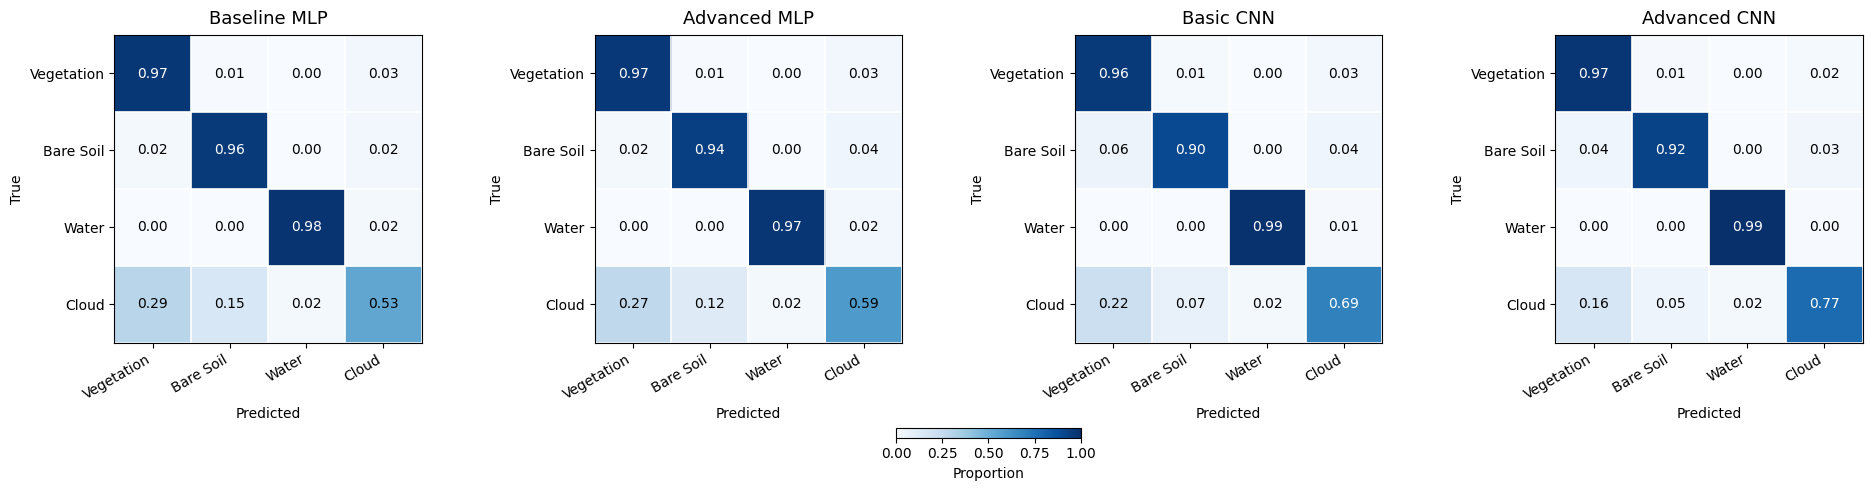

In [128]:
CLASS_NAMES = ["Vegetation","Bare Soil","Water","Cloud"]

fig = plot_confusion_grid_pretty(
    results, CLASS_NAMES,
    normalize="true",      # rows sum to 1 (recall view)
    cmap="Blues",
    show_counts=False,     # keep uncluttered
    show_perc=True,
    decimals=2,
    figsize_per_panel=(4.8, 4.8),
    suptitle="Test Confusion Matrices (Row-Normalized) \n"
)
#fig.savefig("confusions_test_pretty_rownorm.png", dpi=180, bbox_inches="tight")
plt.show()
